In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from rich.progress import track
from rich import progress
import IPython
import pandas as pd

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    Force,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
    PlateElectrodes,
)
from centrex_trajectories.visualization import plot_beamline

C:\Users\ogras\AppData\Local\Temp\ipykernel_29324\2876790632.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{( task.speed or 0 ):.1f}/s"
        else:
            return f"{( 1 / task.speed or 0):.1f} s/i"

In [4]:
n_trajectories = 10_000_000
options = PropagationOptions(verbose=False, n_cores=8)
gravity = Gravity(0, -9.81, 0)
particle = TlF()

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters
wx_det = 13e-3
wy_det = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3

## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture width | 8 mm |
| rc aperture height | 6 mm | 

In [5]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=1e-2,
        ),
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = Section(
    name="Electrostatic Lens",
    objects=[],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
    + 1e-3,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

In [6]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

sections = [fourK, fourtyK, bbexit, rc, spa, eql]
section_data, trajectories = propagate_trajectories(
    sections,
    origin,
    velocities,
    particle,
    force=gravity,
    options=options,
)

In [7]:
traj = trajectories[list(trajectories.keys())[0]]

fig, ax = plt.subplots()
ax.plot(traj.z, traj.x)
ax.plot(traj.z, traj.y)

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x&y [m]")

ax.grid(True)

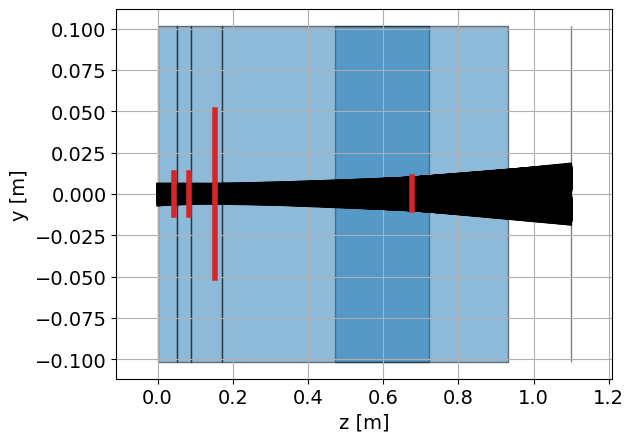

In [8]:
fig, ax = plt.subplots()
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

## Scan with EQL and DET

In [9]:
def scan_function(
    origin: Coordinates,
    velocities: Velocities,
    rc_radius: float,
    eql_voltage: float,
    distance_det: float,
    eql_length: float = 0.6,
    eql_radius: float = 0.022225,
    wx_det: float = 2e-2,
    wy_det: float = 1 * in_to_m,
    wx_int: float = 2e-2,
    wy_int: float = 3 * in_to_m,
):
    rc = Section(
        name="Rotational cooling",
        objects=[
            CircularAperture(
                x=0,
                y=0,
                z=bbexit.stop
                + rc_chamber_center_from_bs_front
                + rc_aperture_from_center,
                r=rc_radius,
            ),
        ],
        start=bbexit.stop
        + bs_flange
        + rc_chamber_center_from_bs_front
        - rc_chamber_length_no_flanges / 2,
        stop=bbexit.stop
        + rc_chamber_center_from_bs_front
        + rc_chamber_length_no_flanges / 2,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=eql_length,
                radius=R,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + eql_length,
        V=eql_voltage,
        R=eql_radius,
        save_collisions=True,
    )

    pre_interaction_aperture = Section(
        name="Pre-Interaction Aperture",
        objects=[
            RectangularAperture(x=0, y=0, z=eql.stop + 1.4925, wx=wx_int, wy=wy_int)
        ],
        start=eql.stop + 1.49,
        stop=eql.stop + 1.495,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    interaction = Section(
        name="Interaction",
        objects=[
            PlateElectrodes(
                x=0, y=0, z=eql.stop + 1.5, length=2.5, width=20e-2, separation=2e-2
            ),
        ],
        start=eql.stop + 1.5,
        stop=eql.stop + 4,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + distance_det,
                wx_det,
                wy_det,
            )
        ],
        start=eql.stop + distance_det - 1e-3,
        stop=eql.stop + distance_det + 1e-3,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [
        fourK,
        fourtyK,
        bbexit,
        rc,
        spa,
        eql,
        pre_interaction_aperture,
        interaction,
        det,
    ]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [14]:
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

radii = np.arange(1e-3, 1.75 / 2 * in_to_m, 2e-3)
voltages = np.linspace(0, 30e3, 13)

data = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("radius", total=len(radii))
    t2 = pb.add_task("voltage", total=len(voltages))
    for idr, radius in enumerate(radii):
        dat = []
        for idv, voltage in enumerate(voltages):
            dat.append(
                scan_function(origin, velocities, radius, voltage, distance_det=5.0)
            )
            pb.update(task_id=t2, completed=idv + 1)
        if idr < len(radii) - 1:
            pb.reset(t2)
        pb.update(task_id=t1, completed=idr + 1)
        data.append((radius, dat))
    pb.refresh()

Output()

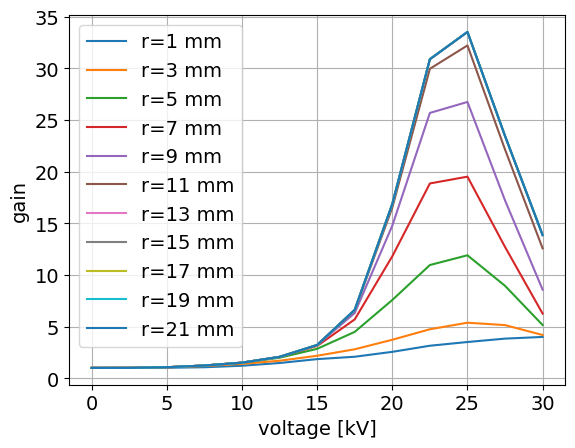

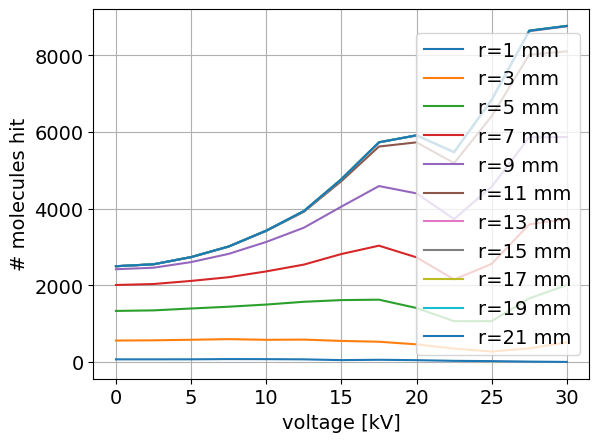

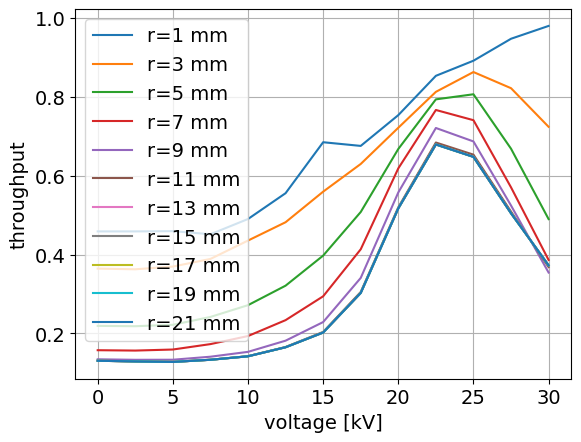

In [15]:
survived = np.array(
    [[sec_dat[-1].survived for sec_dat, _, _ in dat] for _, dat in data]
)
hit = np.array(
    [[sec_dat[-1].nr_collisions for sec_dat, _, _ in dat] for _, dat in data]
)
throughput = np.array(
    [[sec_dat[-1].throughput for sec_dat, _, _ in dat] for _, dat in data]
)

labels = [f"r={r*1e3:.0f} mm" for r in radii][: len(survived)]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules through")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T / survived.T[0, :], label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, hit.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules hit")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, throughput.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("throughput")
ax.legend()
ax.grid(True)

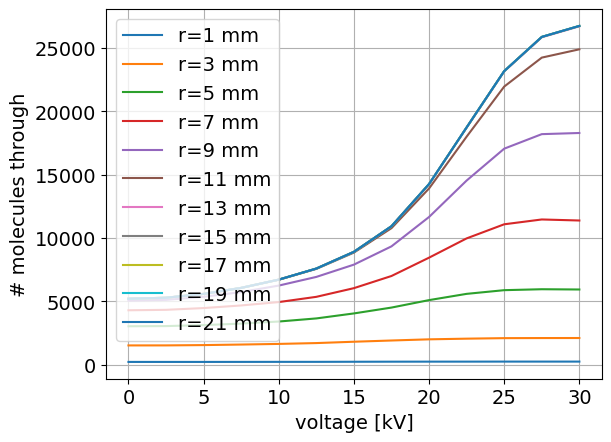

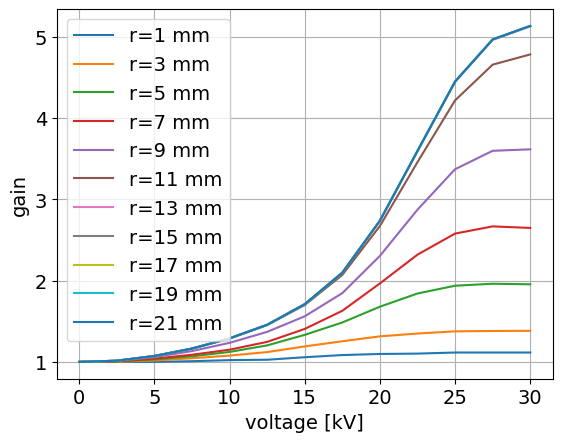

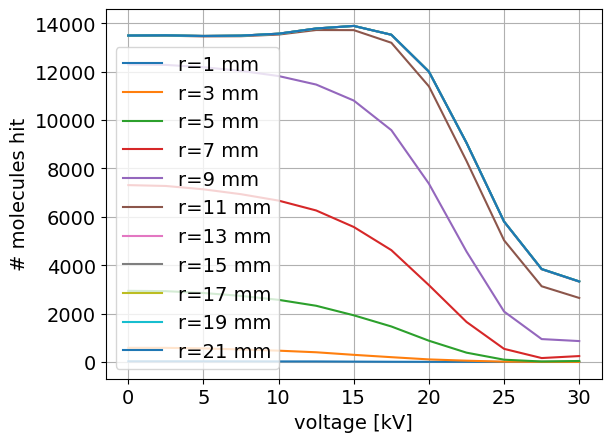

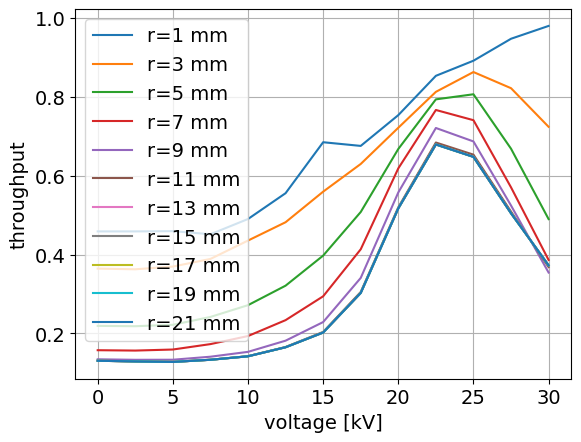

In [16]:
survived = np.array(
    [[sec_dat[-3].survived for sec_dat, _, _ in dat] for _, dat in data]
)
hit = np.array(
    [[sec_dat[-3].nr_collisions for sec_dat, _, _ in dat] for _, dat in data]
)
througput = np.array(
    [[sec_dat[-3].throughput for sec_dat, _, _ in dat] for _, dat in data]
)

labels = [f"r={r*1e3:.0f} mm" for r in radii][: len(survived)]

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules through")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, survived.T / survived.T[0, :], label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, hit.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("# molecules hit")
ax.legend()
ax.grid(True)

fig, ax = plt.subplots()
ax.plot(voltages / 1e3, throughput.T, label=labels)

ax.set_xlabel("voltage [kV]")
ax.set_ylabel("throughput")
ax.legend()
ax.grid(True)

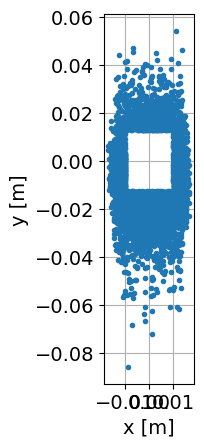

In [17]:
collisions_det = [
    [sec_dat[-1].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]

col = collisions_det[-6][-3][0][0]

fig, ax = plt.subplots()
ax.plot(col.x, col.y, ".")
ax.set_aspect(1)
ax.set_xlim(-2e-2, 2e-2)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

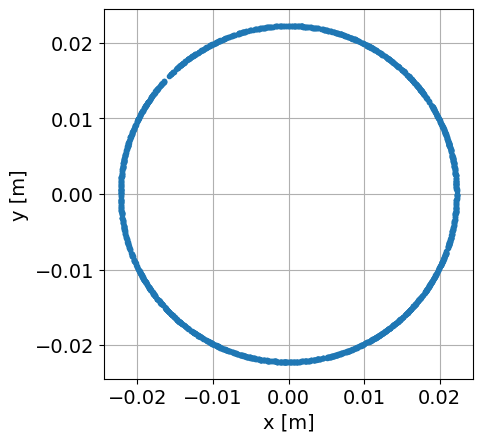

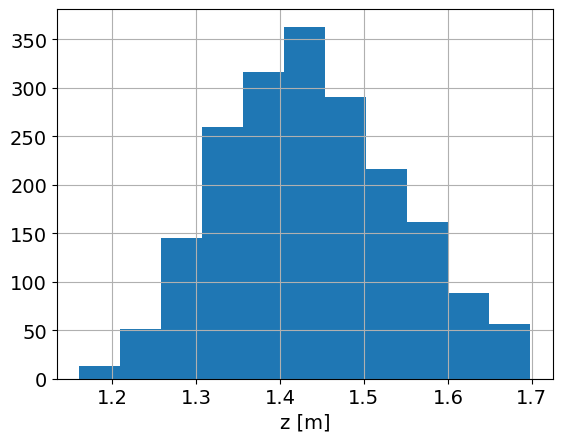

In [67]:
collisions_lens_entry = [
    [sec_dat[-4].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]


col = collisions_lens_entry[-6][-3][1][0]
vel = collisions_lens_entry[-6][-3][1][1]

fig, ax = plt.subplots()
ax.plot(col.x, col.y, ".")
# ax.add_patch(plt.Circle((0, 0), radius=R, fill=False, color="k", lw=3, zorder=10))
ax.set_aspect(1)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

fig, ax = plt.subplots()
ax.hist(col.z, bins=11)
ax.set_xlabel("z [m]")
ax.grid(True)

In [69]:
fig, ax = plt.subplots()
for idx in reversed(range(len(radii))):
    try:
        col = collisions_lens_entry[idx][-3][1][0]
    except:
        continue

    ax.hist(col.z, bins=11, label=f"r={radii[idx]*1e3:.1f} mm")

ax.legend()
ax.set_xlabel("z [m]")
ax.grid(True)

: 

In [52]:
collisions_interaction = [
    [sec_dat[-2].saved_collisions for sec_dat, _, _ in dat] for _, dat in data
]

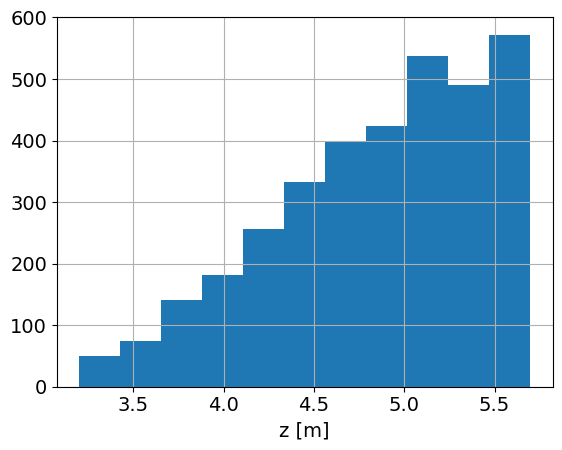

In [53]:
col = collisions_interaction[-6][-3][0][0]
vel = collisions_interaction[-6][-3][0][1]

m = ~(((col.x > 0) & (vel.vx < 0)) | ((col.x < 0) & (vel.vx > 0)))

fig, ax = plt.subplots()
ax.plot(col.x[m], col.y[m], ".")
# ax.set_aspect(1)

ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

fig, ax = plt.subplots()
ax.hist(col.z[m], bins=11)
ax.set_xlabel("z [m]")
ax.grid(True)

In [62]:
fig, ax = plt.subplots()
for idx in reversed(range(len(radii))):
    col = collisions_interaction[idx][-3][0][0]
    vel = collisions_interaction[idx][-3][0][1]

    m = ~(((col.x > 0) & (vel.vx < 0)) | ((col.x < 0) & (vel.vx > 0)))

    ax.hist(col.z[m], bins=11, label=f"r={radii[idx]*1e3:.1f} mm")

ax.legend()
ax.set_xlabel("z [m]")
ax.grid(True)

In [50]:
fig, ax = plt.subplots()
ax.hexbin(col.y[m], col.z[m], gridsize=15)

ax.grid(True)

## Bayesian Optimization

In [263]:
def objective_function(parametrization) -> dict:
    rc_radius = parametrization.get("rc_radius")
    wx_int = parametrization.get("wx_int")
    wx_det = 2e-2
    eql_voltage = parametrization.get("eql_voltage")
    distance_det = 5.0

    section_data, trajectories, sections = scan_function(
        origin=origin,
        velocities=velocities,
        rc_radius=rc_radius,
        eql_voltage=eql_voltage,
        distance_det=distance_det,
        wx_int=wx_int,
        wx_det=wx_det,
    )
    assert section_data[-2].name == "Interaction"
    return {
        "detected": (section_data[-1].survived, np.sqrt(section_data[-1].survived)),
        "hit_interaction": (
            section_data[-2].nr_collisions,
            np.sqrt(section_data[-2].nr_collisions),
        ),
    }

In [264]:
import torch
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

# Plotting imports and initialization
from ax.utils.notebook.plotting import init_notebook_plotting, render

init_notebook_plotting()

[INFO 02-14 11:58:50] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 02-14 11:58:50] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


In [280]:
ax_client = AxClient()

ax_client.create_experiment(
    name="aperture_placement",
    parameters=[
        {
            "name": "rc_radius",
            "type": "range",
            "bounds": [5e-3, 20e-3],
        },
        {"name": "wx_int", "type": "range", "bounds": [1e-3, 20e-3]},
        {"name": "eql_voltage", "type": "range", "bounds": [0.0, 30e3]},
    ],
    objectives={
        # `threshold` arguments are optional
        "detected": ObjectiveProperties(minimize=False, threshold=None),
        "hit_interaction": ObjectiveProperties(minimize=True, threshold=None),
    },
    overwrite_existing_experiment=True,
    is_test=False,
)

[INFO 02-14 14:13:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter rc_radius. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter wx_int. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-14 14:13:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter eql_voltage. If t

In [281]:
optimization_steps = 200

with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("multi-objective optimize", total=optimization_steps)
    for i in range(optimization_steps):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(
            trial_index=trial_index, raw_data=objective_function(parameters)
        )
        pb.update(task_id=t1, completed=i + 1)
        pb.refresh()

Output()

[INFO 02-14 14:13:23] ax.service.ax_client: Generated new trial 0 with parameters {'rc_radius': 0.018622, 'wx_int': 0.008391, 'eql_voltage': 17622.224092}.


[INFO 02-14 14:14:00] ax.service.ax_client: Completed trial 0 with data: {'detected': (1480, 38.470768), 'hit_interaction': (11, 3.316625)}.


[INFO 02-14 14:14:00] ax.service.ax_client: Generated new trial 1 with parameters {'rc_radius': 0.015808, 'wx_int': 0.005086, 'eql_voltage': 16415.737113}.


[INFO 02-14 14:14:35] ax.service.ax_client: Completed trial 1 with data: {'detected': (680, 26.07681), 'hit_interaction': (1, 1.0)}.


[INFO 02-14 14:14:35] ax.service.ax_client: Generated new trial 2 with parameters {'rc_radius': 0.01408, 'wx_int': 0.011824, 'eql_voltage': 20673.33349}.


[INFO 02-14 14:15:11] ax.service.ax_client: Completed trial 2 with data: {'detected': (5241, 72.394751), 'hit_interaction': (236, 15.362291)}.


[INFO 02-14 14:15:11] ax.service.ax_client: Generated new trial 3 with parameters {'rc_radius': 0.017354, 'wx_int': 0.019023, 'eql_voltage': 21078.467807}.


[INFO 02-14 14:15:49] ax.service.ax_client: Completed trial 3 with data: {'detected': (8650, 93.005376), 'hit_interaction': (1459, 38.196859)}.


[INFO 02-14 14:15:49] ax.service.ax_client: Generated new trial 4 with parameters {'rc_radius': 0.008708, 'wx_int': 0.005952, 'eql_voltage': 1278.388733}.


[INFO 02-14 14:16:07] ax.service.ax_client: Completed trial 4 with data: {'detected': (230, 15.165751), 'hit_interaction': (0, 0.0)}.


[INFO 02-14 14:16:07] ax.service.ax_client: Generated new trial 5 with parameters {'rc_radius': 0.014143, 'wx_int': 0.019099, 'eql_voltage': 22779.786112}.


[INFO 02-14 14:16:45] ax.service.ax_client: Completed trial 5 with data: {'detected': (11882, 109.004587), 'hit_interaction': (1687, 41.073106)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:16:50] ax.service.ax_client: Generated new trial 6 with parameters {'rc_radius': 0.011104, 'wx_int': 0.012159, 'eql_voltage': 29965.464958}.


[INFO 02-14 14:17:23] ax.service.ax_client: Completed trial 6 with data: {'detected': (3696, 60.794737), 'hit_interaction': (10764, 103.749699)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:17:28] ax.service.ax_client: Generated new trial 7 with parameters {'rc_radius': 0.012675, 'wx_int': 0.017232, 'eql_voltage': 16467.489423}.


[INFO 02-14 14:18:00] ax.service.ax_client: Completed trial 7 with data: {'detected': (1709, 41.340053), 'hit_interaction': (1694, 41.158231)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:18:10] ax.service.ax_client: Generated new trial 8 with parameters {'rc_radius': 0.016444, 'wx_int': 0.013949, 'eql_voltage': 22409.296579}.


[INFO 02-14 14:18:48] ax.service.ax_client: Completed trial 8 with data: {'detected': (8871, 94.185986), 'hit_interaction': (864, 29.393877)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:18:57] ax.service.ax_client: Generated new trial 9 with parameters {'rc_radius': 0.017007, 'wx_int': 0.007275, 'eql_voltage': 21599.635153}.


[INFO 02-14 14:19:34] ax.service.ax_client: Completed trial 9 with data: {'detected': (4127, 64.241731), 'hit_interaction': (251, 15.84298)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:19:42] ax.service.ax_client: Generated new trial 10 with parameters {'rc_radius': 0.015648, 'wx_int': 0.00918, 'eql_voltage': 19954.650352}.


[INFO 02-14 14:20:17] ax.service.ax_client: Completed trial 10 with data: {'detected': (3360, 57.965507), 'hit_interaction': (70, 8.3666)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:20:24] ax.service.ax_client: Generated new trial 11 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 6875.159891}.


[INFO 02-14 14:20:53] ax.service.ax_client: Completed trial 11 with data: {'detected': (44, 6.63325), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:20:57] ax.service.ax_client: Generated new trial 12 with parameters {'rc_radius': 0.02, 'wx_int': 0.008799, 'eql_voltage': 0.0}.


[INFO 02-14 14:21:23] ax.service.ax_client: Completed trial 12 with data: {'detected': (341, 18.466185), 'hit_interaction': (4, 2.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:21:30] ax.service.ax_client: Generated new trial 13 with parameters {'rc_radius': 0.014695, 'wx_int': 0.015836, 'eql_voltage': 22756.989406}.


[INFO 02-14 14:22:08] ax.service.ax_client: Completed trial 13 with data: {'detected': (10320, 101.587401), 'hit_interaction': (1248, 35.327043)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:22:15] ax.service.ax_client: Generated new trial 14 with parameters {'rc_radius': 0.01657, 'wx_int': 0.001, 'eql_voltage': 0.0}.


[INFO 02-14 14:22:41] ax.service.ax_client: Completed trial 14 with data: {'detected': (40, 6.324555), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:22:50] ax.service.ax_client: Generated new trial 15 with parameters {'rc_radius': 0.01527, 'wx_int': 0.01243, 'eql_voltage': 21820.937812}.


[INFO 02-14 14:23:28] ax.service.ax_client: Completed trial 15 with data: {'detected': (7281, 85.328776), 'hit_interaction': (511, 22.605309)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:23:37] ax.service.ax_client: Generated new trial 16 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 17542.57427}.


[INFO 02-14 14:24:11] ax.service.ax_client: Completed trial 16 with data: {'detected': (166, 12.884099), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:24:21] ax.service.ax_client: Generated new trial 17 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 8257.898557}.


[INFO 02-14 14:24:32] ax.service.ax_client: Completed trial 17 with data: {'detected': (48, 6.928203), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:24:42] ax.service.ax_client: Generated new trial 18 with parameters {'rc_radius': 0.005, 'wx_int': 0.005298, 'eql_voltage': 20408.701929}.


[INFO 02-14 14:24:54] ax.service.ax_client: Completed trial 18 with data: {'detected': (1237, 35.171011), 'hit_interaction': (4, 2.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:25:06] ax.service.ax_client: Generated new trial 19 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 14984.695766}.


[INFO 02-14 14:25:17] ax.service.ax_client: Completed trial 19 with data: {'detected': (89, 9.433981), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:25:25] ax.service.ax_client: Generated new trial 20 with parameters {'rc_radius': 0.005, 'wx_int': 0.02, 'eql_voltage': 0.0}.


[INFO 02-14 14:25:35] ax.service.ax_client: Completed trial 20 with data: {'detected': (383, 19.570386), 'hit_interaction': (1286, 35.860842)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:25:47] ax.service.ax_client: Generated new trial 21 with parameters {'rc_radius': 0.015735, 'wx_int': 0.004757, 'eql_voltage': 3556.497216}.


[INFO 02-14 14:26:16] ax.service.ax_client: Completed trial 21 with data: {'detected': (187, 13.674794), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:26:26] ax.service.ax_client: Generated new trial 22 with parameters {'rc_radius': 0.009583, 'wx_int': 0.008243, 'eql_voltage': 19965.719634}.


[INFO 02-14 14:26:50] ax.service.ax_client: Completed trial 22 with data: {'detected': (2849, 53.376025), 'hit_interaction': (39, 6.244998)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:27:01] ax.service.ax_client: Generated new trial 23 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 12182.019972}.


[INFO 02-14 14:27:32] ax.service.ax_client: Completed trial 23 with data: {'detected': (74, 8.602325), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:27:42] ax.service.ax_client: Generated new trial 24 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 2555.588386}.


[INFO 02-14 14:27:52] ax.service.ax_client: Completed trial 24 with data: {'detected': (39, 6.244998), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:28:05] ax.service.ax_client: Generated new trial 25 with parameters {'rc_radius': 0.02, 'wx_int': 0.02, 'eql_voltage': 24288.230705}.


[INFO 02-14 14:28:45] ax.service.ax_client: Completed trial 25 with data: {'detected': (13013, 114.074537), 'hit_interaction': (2996, 54.735729)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:28:57] ax.service.ax_client: Generated new trial 26 with parameters {'rc_radius': 0.01354, 'wx_int': 0.02, 'eql_voltage': 23866.503148}.


[INFO 02-14 14:29:35] ax.service.ax_client: Completed trial 26 with data: {'detected': (12976, 113.912247), 'hit_interaction': (2513, 50.129831)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:29:53] ax.service.ax_client: Generated new trial 27 with parameters {'rc_radius': 0.013871, 'wx_int': 0.01989, 'eql_voltage': 23189.492683}.


[INFO 02-14 14:30:32] ax.service.ax_client: Completed trial 27 with data: {'detected': (12559, 112.066944), 'hit_interaction': (1987, 44.575778)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:30:53] ax.service.ax_client: Generated new trial 28 with parameters {'rc_radius': 0.02, 'wx_int': 0.006099, 'eql_voltage': 18542.589787}.


[INFO 02-14 14:31:28] ax.service.ax_client: Completed trial 28 with data: {'detected': (1434, 37.868192), 'hit_interaction': (4, 2.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:31:45] ax.service.ax_client: Generated new trial 29 with parameters {'rc_radius': 0.010852, 'wx_int': 0.004044, 'eql_voltage': 19141.139888}.


[INFO 02-14 14:32:12] ax.service.ax_client: Completed trial 29 with data: {'detected': (1108, 33.286634), 'hit_interaction': (4, 2.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:32:32] ax.service.ax_client: Generated new trial 30 with parameters {'rc_radius': 0.013076, 'wx_int': 0.014061, 'eql_voltage': 21969.616523}.


[INFO 02-14 14:33:07] ax.service.ax_client: Completed trial 30 with data: {'detected': (8323, 91.230477), 'hit_interaction': (683, 26.134269)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:33:28] ax.service.ax_client: Generated new trial 31 with parameters {'rc_radius': 0.012691, 'wx_int': 0.01812, 'eql_voltage': 22619.847503}.


[INFO 02-14 14:34:03] ax.service.ax_client: Completed trial 31 with data: {'detected': (11236, 106.0), 'hit_interaction': (1431, 37.828561)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:34:30] ax.service.ax_client: Generated new trial 32 with parameters {'rc_radius': 0.012387, 'wx_int': 0.016065, 'eql_voltage': 22269.808682}.


[INFO 02-14 14:35:05] ax.service.ax_client: Completed trial 32 with data: {'detected': (9802, 99.00505), 'hit_interaction': (1025, 32.015621)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:35:40] ax.service.ax_client: Generated new trial 33 with parameters {'rc_radius': 0.009552, 'wx_int': 0.001, 'eql_voltage': 11372.5596}.


[INFO 02-14 14:36:01] ax.service.ax_client: Completed trial 33 with data: {'detected': (74, 8.602325), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:36:32] ax.service.ax_client: Generated new trial 34 with parameters {'rc_radius': 0.012945, 'wx_int': 0.011894, 'eql_voltage': 21447.824644}.


[INFO 02-14 14:37:07] ax.service.ax_client: Completed trial 34 with data: {'detected': (6452, 80.324343), 'hit_interaction': (374, 19.33908)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:37:25] ax.service.ax_client: Generated new trial 35 with parameters {'rc_radius': 0.02, 'wx_int': 0.004758, 'eql_voltage': 1219.816756}.


[INFO 02-14 14:37:54] ax.service.ax_client: Completed trial 35 with data: {'detected': (183, 13.527749), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:38:11] ax.service.ax_client: Generated new trial 36 with parameters {'rc_radius': 0.011082, 'wx_int': 0.001, 'eql_voltage': 5618.340441}.


[INFO 02-14 14:38:34] ax.service.ax_client: Completed trial 36 with data: {'detected': (41, 6.403124), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:38:57] ax.service.ax_client: Generated new trial 37 with parameters {'rc_radius': 0.013444, 'wx_int': 0.010149, 'eql_voltage': 20628.236623}.


[INFO 02-14 14:39:32] ax.service.ax_client: Completed trial 37 with data: {'detected': (4482, 66.947741), 'hit_interaction': (154, 12.409674)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:39:55] ax.service.ax_client: Generated new trial 38 with parameters {'rc_radius': 0.005, 'wx_int': 0.005615, 'eql_voltage': 18806.855779}.


[INFO 02-14 14:40:06] ax.service.ax_client: Completed trial 38 with data: {'detected': (961, 31.0), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:40:42] ax.service.ax_client: Generated new trial 39 with parameters {'rc_radius': 0.013549, 'wx_int': 0.004858, 'eql_voltage': 0.0}.


[INFO 02-14 14:41:07] ax.service.ax_client: Completed trial 39 with data: {'detected': (188, 13.711309), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:41:34] ax.service.ax_client: Generated new trial 40 with parameters {'rc_radius': 0.016711, 'wx_int': 0.001, 'eql_voltage': 15150.418308}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:42:27] ax.service.ax_client: Generated new trial 41 with parameters {'rc_radius': 0.016034, 'wx_int': 0.005005, 'eql_voltage': 8316.310058}.


[INFO 02-14 14:42:56] ax.service.ax_client: Completed trial 41 with data: {'detected': (236, 15.362291), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:43:13] ax.service.ax_client: Generated new trial 42 with parameters {'rc_radius': 0.015474, 'wx_int': 0.001, 'eql_voltage': 9076.560386}.


[INFO 02-14 14:43:42] ax.service.ax_client: Completed trial 42 with data: {'detected': (53, 7.28011), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:44:02] ax.service.ax_client: Generated new trial 43 with parameters {'rc_radius': 0.005, 'wx_int': 0.005641, 'eql_voltage': 5302.876206}.


[INFO 02-14 14:44:12] ax.service.ax_client: Completed trial 43 with data: {'detected': (229, 15.132746), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:44:31] ax.service.ax_client: Generated new trial 44 with parameters {'rc_radius': 0.014871, 'wx_int': 0.007284, 'eql_voltage': 18440.225777}.


[INFO 02-14 14:45:05] ax.service.ax_client: Completed trial 44 with data: {'detected': (1649, 40.607881), 'hit_interaction': (8, 2.828427)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:45:29] ax.service.ax_client: Generated new trial 45 with parameters {'rc_radius': 0.014166, 'wx_int': 0.018322, 'eql_voltage': 23501.327732}.


[INFO 02-14 14:46:08] ax.service.ax_client: Completed trial 45 with data: {'detected': (12100, 110.0), 'hit_interaction': (2027, 45.022217)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:46:27] ax.service.ax_client: Generated new trial 46 with parameters {'rc_radius': 0.02, 'wx_int': 0.005782, 'eql_voltage': 17074.128299}.


[INFO 02-14 14:47:03] ax.service.ax_client: Completed trial 46 with data: {'detected': (884, 29.732137), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:47:22] ax.service.ax_client: Generated new trial 47 with parameters {'rc_radius': 0.008636, 'wx_int': 0.001, 'eql_voltage': 17555.598834}.


[INFO 02-14 14:47:42] ax.service.ax_client: Completed trial 47 with data: {'detected': (161, 12.688578), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:48:04] ax.service.ax_client: Generated new trial 48 with parameters {'rc_radius': 0.012083, 'wx_int': 0.003881, 'eql_voltage': 6775.562084}.


[INFO 02-14 14:48:29] ax.service.ax_client: Completed trial 48 with data: {'detected': (169, 13.0), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:48:50] ax.service.ax_client: Generated new trial 49 with parameters {'rc_radius': 0.011394, 'wx_int': 0.017235, 'eql_voltage': 22683.79932}.


[INFO 02-14 14:49:23] ax.service.ax_client: Completed trial 49 with data: {'detected': (10756, 103.711137), 'hit_interaction': (1282, 35.805028)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:49:37] ax.service.ax_client: Generated new trial 50 with parameters {'rc_radius': 0.02, 'wx_int': 0.010172, 'eql_voltage': 4251.09462}.


[INFO 02-14 14:50:05] ax.service.ax_client: Completed trial 50 with data: {'detected': (387, 19.672316), 'hit_interaction': (40, 6.324555)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:50:24] ax.service.ax_client: Generated new trial 51 with parameters {'rc_radius': 0.011185, 'wx_int': 0.013927, 'eql_voltage': 21729.526408}.


[INFO 02-14 14:50:56] ax.service.ax_client: Completed trial 51 with data: {'detected': (7754, 88.0568), 'hit_interaction': (560, 23.664319)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:51:22] ax.service.ax_client: Generated new trial 52 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 20934.154028}.


[INFO 02-14 14:51:58] ax.service.ax_client: Completed trial 52 with data: {'detected': (481, 21.931712), 'hit_interaction': (27, 5.196152)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:52:22] ax.service.ax_client: Generated new trial 53 with parameters {'rc_radius': 0.009172, 'wx_int': 0.015595, 'eql_voltage': 22303.964637}.


[INFO 02-14 14:52:46] ax.service.ax_client: Completed trial 53 with data: {'detected': (8444, 91.89124), 'hit_interaction': (669, 25.865034)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:52:58] ax.service.ax_client: Generated new trial 54 with parameters {'rc_radius': 0.005, 'wx_int': 0.011727, 'eql_voltage': 21040.376747}.


[INFO 02-14 14:53:10] ax.service.ax_client: Completed trial 54 with data: {'detected': (2738, 52.325902), 'hit_interaction': (57, 7.549834)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:53:22] ax.service.ax_client: Generated new trial 55 with parameters {'rc_radius': 0.02, 'wx_int': 0.00553, 'eql_voltage': 6541.462674}.


[INFO 02-14 14:53:52] ax.service.ax_client: Completed trial 55 with data: {'detected': (235, 15.32971), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:54:06] ax.service.ax_client: Generated new trial 56 with parameters {'rc_radius': 0.007915, 'wx_int': 0.003938, 'eql_voltage': 3562.572976}.


[INFO 02-14 14:54:24] ax.service.ax_client: Completed trial 56 with data: {'detected': (156, 12.489996), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:54:39] ax.service.ax_client: Generated new trial 57 with parameters {'rc_radius': 0.010086, 'wx_int': 0.02, 'eql_voltage': 23790.016926}.


[INFO 02-14 14:55:08] ax.service.ax_client: Completed trial 57 with data: {'detected': (11836, 108.793382), 'hit_interaction': (2021, 44.955534)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:55:19] ax.service.ax_client: Generated new trial 58 with parameters {'rc_radius': 0.008007, 'wx_int': 0.001, 'eql_voltage': 21919.56974}.


[INFO 02-14 14:55:39] ax.service.ax_client: Completed trial 58 with data: {'detected': (495, 22.248595), 'hit_interaction': (29, 5.385165)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:55:49] ax.service.ax_client: Generated new trial 59 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 19877.621317}.


[INFO 02-14 14:56:01] ax.service.ax_client: Completed trial 59 with data: {'detected': (204, 14.282857), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:56:12] ax.service.ax_client: Generated new trial 60 with parameters {'rc_radius': 0.02, 'wx_int': 0.008222, 'eql_voltage': 2284.840527}.


[INFO 02-14 14:56:40] ax.service.ax_client: Completed trial 60 with data: {'detected': (325, 18.027756), 'hit_interaction': (2, 1.414214)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:56:59] ax.service.ax_client: Generated new trial 61 with parameters {'rc_radius': 0.011217, 'wx_int': 0.014601, 'eql_voltage': 22937.898488}.


[INFO 02-14 14:57:32] ax.service.ax_client: Completed trial 61 with data: {'detected': (9615, 98.056106), 'hit_interaction': (1164, 34.117444)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:57:43] ax.service.ax_client: Generated new trial 62 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 0.0}.


[INFO 02-14 14:57:53] ax.service.ax_client: Completed trial 62 with data: {'detected': (39, 6.244998), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:58:20] ax.service.ax_client: Generated new trial 63 with parameters {'rc_radius': 0.008664, 'wx_int': 0.014212, 'eql_voltage': 21122.302655}.


[INFO 02-14 14:58:43] ax.service.ax_client: Completed trial 63 with data: {'detected': (5984, 77.356318), 'hit_interaction': (338, 18.384776)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:59:02] ax.service.ax_client: Generated new trial 64 with parameters {'rc_radius': 0.012541, 'wx_int': 0.001, 'eql_voltage': 20407.107251}.


[INFO 02-14 14:59:34] ax.service.ax_client: Completed trial 64 with data: {'detected': (419, 20.469489), 'hit_interaction': (16, 4.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 14:59:54] ax.service.ax_client: Generated new trial 65 with parameters {'rc_radius': 0.005, 'wx_int': 0.009351, 'eql_voltage': 19965.436389}.


[INFO 02-14 15:00:05] ax.service.ax_client: Completed trial 65 with data: {'detected': (1931, 43.943145), 'hit_interaction': (14, 3.741657)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:00:17] ax.service.ax_client: Generated new trial 66 with parameters {'rc_radius': 0.02, 'wx_int': 0.02, 'eql_voltage': 26730.867009}.


[INFO 02-14 15:01:00] ax.service.ax_client: Completed trial 66 with data: {'detected': (10193, 100.960388), 'hit_interaction': (6878, 82.933708)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:01:30] ax.service.ax_client: Generated new trial 67 with parameters {'rc_radius': 0.010604, 'wx_int': 0.001, 'eql_voltage': 1189.101656}.


[INFO 02-14 15:01:50] ax.service.ax_client: Completed trial 67 with data: {'detected': (40, 6.324555), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:02:08] ax.service.ax_client: Generated new trial 68 with parameters {'rc_radius': 0.011116, 'wx_int': 0.015908, 'eql_voltage': 22093.35279}.


[INFO 02-14 15:02:39] ax.service.ax_client: Completed trial 68 with data: {'detected': (9199, 95.911417), 'hit_interaction': (865, 29.410882)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:02:59] ax.service.ax_client: Generated new trial 69 with parameters {'rc_radius': 0.02, 'wx_int': 0.008797, 'eql_voltage': 19114.621042}.


[INFO 02-14 15:03:35] ax.service.ax_client: Completed trial 69 with data: {'detected': (2442, 49.416596), 'hit_interaction': (26, 5.09902)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:03:55] ax.service.ax_client: Generated new trial 70 with parameters {'rc_radius': 0.011614, 'wx_int': 0.016912, 'eql_voltage': 22406.648492}.


[INFO 02-14 15:04:28] ax.service.ax_client: Completed trial 70 with data: {'detected': (10277, 101.375539), 'hit_interaction': (1163, 34.102786)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:04:49] ax.service.ax_client: Generated new trial 71 with parameters {'rc_radius': 0.02, 'wx_int': 0.003679, 'eql_voltage': 9907.085377}.


[INFO 02-14 15:05:21] ax.service.ax_client: Completed trial 71 with data: {'detected': (198, 14.071247), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:05:44] ax.service.ax_client: Generated new trial 72 with parameters {'rc_radius': 0.005, 'wx_int': 0.001834, 'eql_voltage': 5811.71813}.


[INFO 02-14 15:05:54] ax.service.ax_client: Completed trial 72 with data: {'detected': (90, 9.486833), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:06:12] ax.service.ax_client: Generated new trial 73 with parameters {'rc_radius': 0.005, 'wx_int': 0.004786, 'eql_voltage': 9618.559754}.


[INFO 02-14 15:06:23] ax.service.ax_client: Completed trial 73 with data: {'detected': (244, 15.620499), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:06:39] ax.service.ax_client: Generated new trial 74 with parameters {'rc_radius': 0.011505, 'wx_int': 0.003051, 'eql_voltage': 13600.665336}.


[INFO 02-14 15:07:06] ax.service.ax_client: Completed trial 74 with data: {'detected': (248, 15.748016), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:07:20] ax.service.ax_client: Generated new trial 75 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 3818.189824}.


[INFO 02-14 15:07:48] ax.service.ax_client: Completed trial 75 with data: {'detected': (40, 6.324555), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:08:25] ax.service.ax_client: Generated new trial 76 with parameters {'rc_radius': 0.005, 'wx_int': 0.002398, 'eql_voltage': 12060.688629}.


[INFO 02-14 15:08:36] ax.service.ax_client: Completed trial 76 with data: {'detected': (172, 13.114877), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:08:48] ax.service.ax_client: Generated new trial 77 with parameters {'rc_radius': 0.012834, 'wx_int': 0.007877, 'eql_voltage': 4436.300125}.


[INFO 02-14 15:09:14] ax.service.ax_client: Completed trial 77 with data: {'detected': (324, 18.0), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:09:40] ax.service.ax_client: Generated new trial 78 with parameters {'rc_radius': 0.010988, 'wx_int': 0.013332, 'eql_voltage': 21502.027772}.


[INFO 02-14 15:10:10] ax.service.ax_client: Completed trial 78 with data: {'detected': (7069, 84.077345), 'hit_interaction': (456, 21.354157)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:10:28] ax.service.ax_client: Generated new trial 79 with parameters {'rc_radius': 0.010118, 'wx_int': 0.010285, 'eql_voltage': 20352.542666}.


[INFO 02-14 15:10:55] ax.service.ax_client: Completed trial 79 with data: {'detected': (3999, 63.237647), 'hit_interaction': (104, 10.198039)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:11:13] ax.service.ax_client: Generated new trial 80 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 25926.584448}.


[INFO 02-14 15:11:52] ax.service.ax_client: Completed trial 80 with data: {'detected': (786, 28.035692), 'hit_interaction': (640, 25.298221)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:12:14] ax.service.ax_client: Generated new trial 81 with parameters {'rc_radius': 0.02, 'wx_int': 0.004265, 'eql_voltage': 13504.302474}.


[INFO 02-14 15:12:46] ax.service.ax_client: Completed trial 81 with data: {'detected': (352, 18.761663), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:13:10] ax.service.ax_client: Generated new trial 82 with parameters {'rc_radius': 0.011263, 'wx_int': 0.014985, 'eql_voltage': 22127.311479}.


[INFO 02-14 15:13:41] ax.service.ax_client: Completed trial 82 with data: {'detected': (8840, 94.021274), 'hit_interaction': (782, 27.964263)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:14:04] ax.service.ax_client: Generated new trial 83 with parameters {'rc_radius': 0.009792, 'wx_int': 0.003344, 'eql_voltage': 9739.576085}.


[INFO 02-14 15:14:26] ax.service.ax_client: Completed trial 83 with data: {'detected': (176, 13.266499), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:14:43] ax.service.ax_client: Generated new trial 84 with parameters {'rc_radius': 0.005, 'wx_int': 0.004226, 'eql_voltage': 7748.494356}.


[INFO 02-14 15:14:54] ax.service.ax_client: Completed trial 84 with data: {'detected': (193, 13.892444), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:15:23] ax.service.ax_client: Generated new trial 85 with parameters {'rc_radius': 0.012124, 'wx_int': 0.018192, 'eql_voltage': 23063.060861}.


[INFO 02-14 15:15:58] ax.service.ax_client: Completed trial 85 with data: {'detected': (11701, 108.171161), 'hit_interaction': (1647, 40.583248)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:16:24] ax.service.ax_client: Generated new trial 86 with parameters {'rc_radius': 0.005, 'wx_int': 0.004357, 'eql_voltage': 0.0}.


[INFO 02-14 15:16:34] ax.service.ax_client: Completed trial 86 with data: {'detected': (165, 12.845233), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:17:10] ax.service.ax_client: Generated new trial 87 with parameters {'rc_radius': 0.011123, 'wx_int': 0.014384, 'eql_voltage': 21855.678539}.


[INFO 02-14 15:17:41] ax.service.ax_client: Completed trial 87 with data: {'detected': (8148, 90.266273), 'hit_interaction': (624, 24.979992)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:18:17] ax.service.ax_client: Generated new trial 88 with parameters {'rc_radius': 0.02, 'wx_int': 0.006438, 'eql_voltage': 0.0}.


[INFO 02-14 15:18:44] ax.service.ax_client: Completed trial 88 with data: {'detected': (256, 16.0), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:19:13] ax.service.ax_client: Generated new trial 89 with parameters {'rc_radius': 0.012134, 'wx_int': 0.017109, 'eql_voltage': 22866.705431}.


[INFO 02-14 15:19:50] ax.service.ax_client: Completed trial 89 with data: {'detected': (11012, 104.938077), 'hit_interaction': (1416, 37.629775)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:20:22] ax.service.ax_client: Generated new trial 90 with parameters {'rc_radius': 0.010601, 'wx_int': 0.011358, 'eql_voltage': 20776.480197}.


[INFO 02-14 15:20:53] ax.service.ax_client: Completed trial 90 with data: {'detected': (5010, 70.781353), 'hit_interaction': (197, 14.035669)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:21:23] ax.service.ax_client: Generated new trial 91 with parameters {'rc_radius': 0.017306, 'wx_int': 0.02, 'eql_voltage': 24202.338086}.


[INFO 02-14 15:22:04] ax.service.ax_client: Completed trial 91 with data: {'detected': (13038, 114.184062), 'hit_interaction': (2879, 53.656314)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:22:33] ax.service.ax_client: Generated new trial 92 with parameters {'rc_radius': 0.010939, 'wx_int': 0.012027, 'eql_voltage': 21064.333393}.


[INFO 02-14 15:23:04] ax.service.ax_client: Completed trial 92 with data: {'detected': (5781, 76.032888), 'hit_interaction': (275, 16.583124)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:23:35] ax.service.ax_client: Generated new trial 93 with parameters {'rc_radius': 0.008307, 'wx_int': 0.00345, 'eql_voltage': 16434.439855}.


[INFO 02-14 15:23:55] ax.service.ax_client: Completed trial 93 with data: {'detected': (459, 21.424285), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:24:20] ax.service.ax_client: Generated new trial 94 with parameters {'rc_radius': 0.005, 'wx_int': 0.003679, 'eql_voltage': 19542.622124}.


[INFO 02-14 15:24:32] ax.service.ax_client: Completed trial 94 with data: {'detected': (747, 27.331301), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:24:56] ax.service.ax_client: Generated new trial 95 with parameters {'rc_radius': 0.02, 'wx_int': 0.007426, 'eql_voltage': 18037.353601}.


[INFO 02-14 15:25:31] ax.service.ax_client: Completed trial 95 with data: {'detected': (1472, 38.366652), 'hit_interaction': (8, 2.828427)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:26:02] ax.service.ax_client: Generated new trial 96 with parameters {'rc_radius': 0.02, 'wx_int': 0.007145, 'eql_voltage': 4454.037849}.


[INFO 02-14 15:26:30] ax.service.ax_client: Completed trial 96 with data: {'detected': (300, 17.320508), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:27:26] ax.service.ax_client: Generated new trial 97 with parameters {'rc_radius': 0.02, 'wx_int': 0.003155, 'eql_voltage': 19097.816684}.


[INFO 02-14 15:28:02] ax.service.ax_client: Completed trial 97 with data: {'detected': (868, 29.46184), 'hit_interaction': (3, 1.732051)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:28:29] ax.service.ax_client: Generated new trial 98 with parameters {'rc_radius': 0.007736, 'wx_int': 0.005956, 'eql_voltage': 19307.066956}.


[INFO 02-14 15:28:48] ax.service.ax_client: Completed trial 98 with data: {'detected': (1507, 38.820098), 'hit_interaction': (3, 1.732051)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:29:12] ax.service.ax_client: Generated new trial 99 with parameters {'rc_radius': 0.016454, 'wx_int': 0.004122, 'eql_voltage': 17997.244957}.


[INFO 02-14 15:29:46] ax.service.ax_client: Completed trial 99 with data: {'detected': (823, 28.687977), 'hit_interaction': (2, 1.414214)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:30:31] ax.service.ax_client: Generated new trial 100 with parameters {'rc_radius': 0.02, 'wx_int': 0.02, 'eql_voltage': 23302.844383}.


[INFO 02-14 15:31:10] ax.service.ax_client: Completed trial 100 with data: {'detected': (12684, 112.623266), 'hit_interaction': (2056, 45.343136)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:31:52] ax.service.ax_client: Generated new trial 101 with parameters {'rc_radius': 0.011885, 'wx_int': 0.015961, 'eql_voltage': 22563.874667}.


[INFO 02-14 15:32:28] ax.service.ax_client: Completed trial 101 with data: {'detected': (10104, 100.518655), 'hit_interaction': (1119, 33.451457)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:33:07] ax.service.ax_client: Generated new trial 102 with parameters {'rc_radius': 0.02, 'wx_int': 0.003541, 'eql_voltage': 15325.002081}.


[INFO 02-14 15:33:40] ax.service.ax_client: Completed trial 102 with data: {'detected': (377, 19.416488), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:34:23] ax.service.ax_client: Generated new trial 103 with parameters {'rc_radius': 0.011681, 'wx_int': 0.015481, 'eql_voltage': 22360.147712}.


[INFO 02-14 15:34:56] ax.service.ax_client: Completed trial 103 with data: {'detected': (9543, 97.68828), 'hit_interaction': (960, 30.983867)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:35:19] ax.service.ax_client: Generated new trial 104 with parameters {'rc_radius': 0.02, 'wx_int': 0.018533, 'eql_voltage': 23449.441912}.


[INFO 02-14 15:35:59] ax.service.ax_client: Completed trial 104 with data: {'detected': (12158, 110.263321), 'hit_interaction': (2003, 44.754888)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:36:33] ax.service.ax_client: Generated new trial 105 with parameters {'rc_radius': 0.012689, 'wx_int': 0.007485, 'eql_voltage': 6591.948152}.


[INFO 02-14 15:36:59] ax.service.ax_client: Completed trial 105 with data: {'detected': (326, 18.05547), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:37:27] ax.service.ax_client: Generated new trial 106 with parameters {'rc_radius': 0.012742, 'wx_int': 0.019358, 'eql_voltage': 23037.614605}.


[INFO 02-14 15:38:04] ax.service.ax_client: Completed trial 106 with data: {'detected': (12243, 110.648091), 'hit_interaction': (1833, 42.813549)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:38:33] ax.service.ax_client: Generated new trial 107 with parameters {'rc_radius': 0.014337, 'wx_int': 0.00637, 'eql_voltage': 5538.433095}.


[INFO 02-14 15:39:00] ax.service.ax_client: Completed trial 107 with data: {'detected': (272, 16.492423), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:39:45] ax.service.ax_client: Generated new trial 108 with parameters {'rc_radius': 0.01098, 'wx_int': 0.012458, 'eql_voltage': 21223.387855}.


[INFO 02-14 15:40:15] ax.service.ax_client: Completed trial 108 with data: {'detected': (6224, 78.892332), 'hit_interaction': (333, 18.248288)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:40:52] ax.service.ax_client: Generated new trial 109 with parameters {'rc_radius': 0.005, 'wx_int': 0.003521, 'eql_voltage': 1441.662368}.


[INFO 02-14 15:41:03] ax.service.ax_client: Completed trial 109 with data: {'detected': (141, 11.874342), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:41:35] ax.service.ax_client: Generated new trial 110 with parameters {'rc_radius': 0.02, 'wx_int': 0.006471, 'eql_voltage': 15477.169316}.


[INFO 02-14 15:42:09] ax.service.ax_client: Completed trial 110 with data: {'detected': (704, 26.532998), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:42:44] ax.service.ax_client: Generated new trial 111 with parameters {'rc_radius': 0.011438, 'wx_int': 0.01486, 'eql_voltage': 21983.392562}.


[INFO 02-14 15:43:16] ax.service.ax_client: Completed trial 111 with data: {'detected': (8612, 92.800862), 'hit_interaction': (720, 26.832816)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:44:01] ax.service.ax_client: Generated new trial 112 with parameters {'rc_radius': 0.02, 'wx_int': 0.007941, 'eql_voltage': 8372.760702}.


[INFO 02-14 15:44:32] ax.service.ax_client: Completed trial 112 with data: {'detected': (389, 19.723083), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:45:13] ax.service.ax_client: Generated new trial 113 with parameters {'rc_radius': 0.011096, 'wx_int': 0.0137, 'eql_voltage': 21598.609381}.


[INFO 02-14 15:45:44] ax.service.ax_client: Completed trial 113 with data: {'detected': (7419, 86.133617), 'hit_interaction': (511, 22.605309)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:46:30] ax.service.ax_client: Generated new trial 114 with parameters {'rc_radius': 0.02, 'wx_int': 0.00634, 'eql_voltage': 10998.160402}.


[INFO 02-14 15:47:03] ax.service.ax_client: Completed trial 114 with data: {'detected': (379, 19.467922), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:47:40] ax.service.ax_client: Generated new trial 115 with parameters {'rc_radius': 0.013373, 'wx_int': 0.005282, 'eql_voltage': 11492.050171}.


[INFO 02-14 15:48:11] ax.service.ax_client: Completed trial 115 with data: {'detected': (339, 18.411953), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:48:30] ax.service.ax_client: Generated new trial 116 with parameters {'rc_radius': 0.005, 'wx_int': 0.011741, 'eql_voltage': 20042.583142}.


[INFO 02-14 15:48:42] ax.service.ax_client: Completed trial 116 with data: {'detected': (2327, 48.238988), 'hit_interaction': (56, 7.483315)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:49:03] ax.service.ax_client: Generated new trial 117 with parameters {'rc_radius': 0.015682, 'wx_int': 0.007531, 'eql_voltage': 979.988092}.


[INFO 02-14 15:49:32] ax.service.ax_client: Completed trial 117 with data: {'detected': (299, 17.291616), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:50:24] ax.service.ax_client: Generated new trial 118 with parameters {'rc_radius': 0.02, 'wx_int': 0.0063, 'eql_voltage': 8874.056687}.


[INFO 02-14 15:50:55] ax.service.ax_client: Completed trial 118 with data: {'detected': (325, 18.027756), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:51:24] ax.service.ax_client: Generated new trial 119 with parameters {'rc_radius': 0.02, 'wx_int': 0.007965, 'eql_voltage': 6693.376902}.


[INFO 02-14 15:51:53] ax.service.ax_client: Completed trial 119 with data: {'detected': (347, 18.627936), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:52:24] ax.service.ax_client: Generated new trial 120 with parameters {'rc_radius': 0.017044, 'wx_int': 0.003754, 'eql_voltage': 11550.032115}.


[INFO 02-14 15:52:55] ax.service.ax_client: Completed trial 120 with data: {'detected': (248, 15.748016), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:53:19] ax.service.ax_client: Generated new trial 121 with parameters {'rc_radius': 0.011212, 'wx_int': 0.006455, 'eql_voltage': 8874.490897}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:54:29] ax.service.ax_client: Generated new trial 122 with parameters {'rc_radius': 0.010984, 'wx_int': 0.012936, 'eql_voltage': 21440.343061}.


[INFO 02-14 15:54:59] ax.service.ax_client: Completed trial 122 with data: {'detected': (6781, 82.346828), 'hit_interaction': (407, 20.174241)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:55:25] ax.service.ax_client: Generated new trial 123 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 1504.17631}.


[INFO 02-14 15:55:54] ax.service.ax_client: Completed trial 123 with data: {'detected': (40, 6.324555), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:56:56] ax.service.ax_client: Generated new trial 124 with parameters {'rc_radius': 0.010233, 'wx_int': 0.001, 'eql_voltage': 15435.044315}.


[INFO 02-14 15:57:21] ax.service.ax_client: Completed trial 124 with data: {'detected': (93, 9.643651), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:57:49] ax.service.ax_client: Generated new trial 125 with parameters {'rc_radius': 0.005, 'wx_int': 0.004698, 'eql_voltage': 14056.840412}.


[INFO 02-14 15:58:00] ax.service.ax_client: Completed trial 125 with data: {'detected': (403, 20.07486), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 15:58:57] ax.service.ax_client: Generated new trial 126 with parameters {'rc_radius': 0.014477, 'wx_int': 0.005575, 'eql_voltage': 14254.728309}.


[INFO 02-14 15:59:31] ax.service.ax_client: Completed trial 126 with data: {'detected': (504, 22.449944), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:00:03] ax.service.ax_client: Generated new trial 127 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 30000.0}.


[INFO 02-14 16:00:16] ax.service.ax_client: Completed trial 127 with data: {'detected': (390, 19.748418), 'hit_interaction': (161, 12.688578)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:00:51] ax.service.ax_client: Generated new trial 128 with parameters {'rc_radius': 0.005, 'wx_int': 0.00694, 'eql_voltage': 19851.155431}.


[INFO 02-14 16:01:04] ax.service.ax_client: Completed trial 128 with data: {'detected': (1449, 38.065733), 'hit_interaction': (6, 2.44949)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:01:53] ax.service.ax_client: Generated new trial 129 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 21763.251313}.


[INFO 02-14 16:02:06] ax.service.ax_client: Completed trial 129 with data: {'detected': (314, 17.720045), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:02:42] ax.service.ax_client: Generated new trial 130 with parameters {'rc_radius': 0.009858, 'wx_int': 0.005389, 'eql_voltage': 17926.897135}.


[INFO 02-14 16:03:08] ax.service.ax_client: Completed trial 130 with data: {'detected': (1021, 31.953091), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:03:34] ax.service.ax_client: Generated new trial 131 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 25314.364038}.


[INFO 02-14 16:03:46] ax.service.ax_client: Completed trial 131 with data: {'detected': (476, 21.817424), 'hit_interaction': (51, 7.141428)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:04:19] ax.service.ax_client: Generated new trial 132 with parameters {'rc_radius': 0.005, 'wx_int': 0.006763, 'eql_voltage': 3006.111749}.


[INFO 02-14 16:04:30] ax.service.ax_client: Completed trial 132 with data: {'detected': (276, 16.613248), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:05:00] ax.service.ax_client: Generated new trial 133 with parameters {'rc_radius': 0.009274, 'wx_int': 0.00646, 'eql_voltage': 3588.385788}.


[INFO 02-14 16:05:20] ax.service.ax_client: Completed trial 133 with data: {'detected': (264, 16.248077), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:05:43] ax.service.ax_client: Generated new trial 134 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 19345.554476}.


[INFO 02-14 16:06:19] ax.service.ax_client: Completed trial 134 with data: {'detected': (285, 16.881943), 'hit_interaction': (2, 1.414214)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:07:08] ax.service.ax_client: Generated new trial 135 with parameters {'rc_radius': 0.005, 'wx_int': 0.007665, 'eql_voltage': 0.0}.


[INFO 02-14 16:07:19] ax.service.ax_client: Completed trial 135 with data: {'detected': (303, 17.406895), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:08:00] ax.service.ax_client: Generated new trial 136 with parameters {'rc_radius': 0.010348, 'wx_int': 0.007515, 'eql_voltage': 0.0}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:08:56] ax.service.ax_client: Generated new trial 137 with parameters {'rc_radius': 0.009706, 'wx_int': 0.02, 'eql_voltage': 23026.440995}.


[INFO 02-14 16:09:23] ax.service.ax_client: Completed trial 137 with data: {'detected': (11154, 105.612499), 'hit_interaction': (1493, 38.639358)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:10:20] ax.service.ax_client: Generated new trial 138 with parameters {'rc_radius': 0.011967, 'wx_int': 0.016139, 'eql_voltage': 22835.731321}.


[INFO 02-14 16:10:55] ax.service.ax_client: Completed trial 138 with data: {'detected': (10477, 102.357218), 'hit_interaction': (1313, 36.235342)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:11:40] ax.service.ax_client: Generated new trial 139 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 9996.254265}.


[INFO 02-14 16:12:10] ax.service.ax_client: Completed trial 139 with data: {'detected': (60, 7.745967), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:12:39] ax.service.ax_client: Generated new trial 140 with parameters {'rc_radius': 0.007108, 'wx_int': 0.004531, 'eql_voltage': 12317.300982}.


[INFO 02-14 16:12:55] ax.service.ax_client: Completed trial 140 with data: {'detected': (317, 17.804494), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:13:38] ax.service.ax_client: Generated new trial 141 with parameters {'rc_radius': 0.011741, 'wx_int': 0.01467, 'eql_voltage': 22356.133923}.


[INFO 02-14 16:14:11] ax.service.ax_client: Completed trial 141 with data: {'detected': (9127, 95.535334), 'hit_interaction': (877, 29.614186)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:14:59] ax.service.ax_client: Generated new trial 142 with parameters {'rc_radius': 0.005, 'wx_int': 0.003195, 'eql_voltage': 14472.535866}.


[INFO 02-14 16:15:10] ax.service.ax_client: Completed trial 142 with data: {'detected': (285, 16.881943), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:15:44] ax.service.ax_client: Generated new trial 143 with parameters {'rc_radius': 0.02, 'wx_int': 0.003304, 'eql_voltage': 4738.784035}.


[INFO 02-14 16:16:13] ax.service.ax_client: Completed trial 143 with data: {'detected': (140, 11.83216), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:16:43] ax.service.ax_client: Generated new trial 144 with parameters {'rc_radius': 0.02, 'wx_int': 0.002891, 'eql_voltage': 0.0}.


[INFO 02-14 16:17:10] ax.service.ax_client: Completed trial 144 with data: {'detected': (123, 11.090537), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:18:18] ax.service.ax_client: Generated new trial 145 with parameters {'rc_radius': 0.010788, 'wx_int': 0.011489, 'eql_voltage': 21010.811109}.


[INFO 02-14 16:18:48] ax.service.ax_client: Completed trial 145 with data: {'detected': (5429, 73.681748), 'hit_interaction': (244, 15.620499)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:19:35] ax.service.ax_client: Generated new trial 146 with parameters {'rc_radius': 0.015957, 'wx_int': 0.002181, 'eql_voltage': 2325.705157}.


[INFO 02-14 16:20:02] ax.service.ax_client: Completed trial 146 with data: {'detected': (97, 9.848858), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:20:55] ax.service.ax_client: Generated new trial 147 with parameters {'rc_radius': 0.016499, 'wx_int': 0.007179, 'eql_voltage': 7798.519195}.


[INFO 02-14 16:21:25] ax.service.ax_client: Completed trial 147 with data: {'detected': (340, 18.439089), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:22:00] ax.service.ax_client: Generated new trial 148 with parameters {'rc_radius': 0.005, 'wx_int': 0.006451, 'eql_voltage': 644.712348}.


[INFO 02-14 16:22:10] ax.service.ax_client: Completed trial 148 with data: {'detected': (255, 15.968719), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:23:07] ax.service.ax_client: Generated new trial 149 with parameters {'rc_radius': 0.005, 'wx_int': 0.007389, 'eql_voltage': 7211.094927}.


[INFO 02-14 16:23:18] ax.service.ax_client: Completed trial 149 with data: {'detected': (335, 18.303005), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:24:12] ax.service.ax_client: Generated new trial 150 with parameters {'rc_radius': 0.007798, 'wx_int': 0.006259, 'eql_voltage': 7230.38669}.


[INFO 02-14 16:24:29] ax.service.ax_client: Completed trial 150 with data: {'detected': (288, 16.970563), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:25:14] ax.service.ax_client: Generated new trial 151 with parameters {'rc_radius': 0.005, 'wx_int': 0.008081, 'eql_voltage': 5087.782606}.


[INFO 02-14 16:25:25] ax.service.ax_client: Completed trial 151 with data: {'detected': (334, 18.275667), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:26:06] ax.service.ax_client: Generated new trial 152 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 17044.813807}.


[INFO 02-14 16:26:17] ax.service.ax_client: Completed trial 152 with data: {'detected': (115, 10.723805), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:26:51] ax.service.ax_client: Generated new trial 153 with parameters {'rc_radius': 0.02, 'wx_int': 0.006335, 'eql_voltage': 13250.296913}.


[INFO 02-14 16:27:24] ax.service.ax_client: Completed trial 153 with data: {'detected': (502, 22.405357), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:28:17] ax.service.ax_client: Generated new trial 154 with parameters {'rc_radius': 0.011617, 'wx_int': 0.013822, 'eql_voltage': 22119.61731}.


[INFO 02-14 16:28:49] ax.service.ax_client: Completed trial 154 with data: {'detected': (8324, 91.235958), 'hit_interaction': (699, 26.438608)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:29:46] ax.service.ax_client: Generated new trial 155 with parameters {'rc_radius': 0.009928, 'wx_int': 0.002447, 'eql_voltage': 0.0}.


[INFO 02-14 16:30:08] ax.service.ax_client: Completed trial 155 with data: {'detected': (105, 10.246951), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:30:44] ax.service.ax_client: Generated new trial 156 with parameters {'rc_radius': 0.009509, 'wx_int': 0.004662, 'eql_voltage': 14900.8258}.


[INFO 02-14 16:31:07] ax.service.ax_client: Completed trial 156 with data: {'detected': (468, 21.633308), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:32:19] ax.service.ax_client: Generated new trial 157 with parameters {'rc_radius': 0.011533, 'wx_int': 0.013558, 'eql_voltage': 21966.72283}.


[INFO 02-14 16:32:51] ax.service.ax_client: Completed trial 157 with data: {'detected': (7975, 89.302855), 'hit_interaction': (614, 24.779023)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:33:34] ax.service.ax_client: Generated new trial 158 with parameters {'rc_radius': 0.010726, 'wx_int': 0.009599, 'eql_voltage': 20202.216737}.


[INFO 02-14 16:34:03] ax.service.ax_client: Completed trial 158 with data: {'detected': (3672, 60.59703), 'hit_interaction': (84, 9.165151)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:34:39] ax.service.ax_client: Generated new trial 159 with parameters {'rc_radius': 0.013681, 'wx_int': 0.001, 'eql_voltage': 13009.276855}.


[INFO 02-14 16:35:11] ax.service.ax_client: Completed trial 159 with data: {'detected': (82, 9.055385), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:35:53] ax.service.ax_client: Generated new trial 160 with parameters {'rc_radius': 0.008296, 'wx_int': 0.008539, 'eql_voltage': 2018.02633}.


[INFO 02-14 16:36:10] ax.service.ax_client: Completed trial 160 with data: {'detected': (331, 18.193405), 'hit_interaction': (2, 1.414214)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:36:43] ax.service.ax_client: Generated new trial 161 with parameters {'rc_radius': 0.02, 'wx_int': 0.002804, 'eql_voltage': 7856.855803}.


[INFO 02-14 16:37:15] ax.service.ax_client: Completed trial 161 with data: {'detected': (140, 11.83216), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:38:09] ax.service.ax_client: Generated new trial 162 with parameters {'rc_radius': 0.01068, 'wx_int': 0.010371, 'eql_voltage': 20537.812777}.


[INFO 02-14 16:38:37] ax.service.ax_client: Completed trial 162 with data: {'detected': (4327, 65.779936), 'hit_interaction': (129, 11.357817)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:39:16] ax.service.ax_client: Generated new trial 163 with parameters {'rc_radius': 0.010902, 'wx_int': 0.012032, 'eql_voltage': 21231.467197}.


[INFO 02-14 16:39:46] ax.service.ax_client: Completed trial 163 with data: {'detected': (6047, 77.762459), 'hit_interaction': (305, 17.464249)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:40:40] ax.service.ax_client: Generated new trial 164 with parameters {'rc_radius': 0.011231, 'wx_int': 0.001, 'eql_voltage': 3598.648077}.


[INFO 02-14 16:41:03] ax.service.ax_client: Completed trial 164 with data: {'detected': (39, 6.244998), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:41:56] ax.service.ax_client: Generated new trial 165 with parameters {'rc_radius': 0.011099, 'wx_int': 0.008988, 'eql_voltage': 19886.094621}.


[INFO 02-14 16:42:26] ax.service.ax_client: Completed trial 165 with data: {'detected': (3162, 56.231664), 'hit_interaction': (54, 7.348469)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:43:05] ax.service.ax_client: Generated new trial 166 with parameters {'rc_radius': 0.011473, 'wx_int': 0.013044, 'eql_voltage': 21914.426597}.


[INFO 02-14 16:43:37] ax.service.ax_client: Completed trial 166 with data: {'detected': (7655, 87.492857), 'hit_interaction': (556, 23.579652)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:44:13] ax.service.ax_client: Generated new trial 167 with parameters {'rc_radius': 0.02, 'wx_int': 0.005456, 'eql_voltage': 14649.811784}.


[INFO 02-14 16:44:46] ax.service.ax_client: Completed trial 167 with data: {'detected': (519, 22.781571), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:45:35] ax.service.ax_client: Generated new trial 168 with parameters {'rc_radius': 0.011322, 'wx_int': 0.012999, 'eql_voltage': 21699.509701}.


[INFO 02-14 16:46:07] ax.service.ax_client: Completed trial 168 with data: {'detected': (7279, 85.317056), 'hit_interaction': (481, 21.931712)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:46:52] ax.service.ax_client: Generated new trial 169 with parameters {'rc_radius': 0.011045, 'wx_int': 0.012295, 'eql_voltage': 21405.282544}.


[INFO 02-14 16:47:23] ax.service.ax_client: Completed trial 169 with data: {'detected': (6429, 80.181045), 'hit_interaction': (354, 18.814888)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:48:30] ax.service.ax_client: Generated new trial 170 with parameters {'rc_radius': 0.010556, 'wx_int': 0.010896, 'eql_voltage': 20736.578007}.


[INFO 02-14 16:49:01] ax.service.ax_client: Completed trial 170 with data: {'detected': (4761, 69.0), 'hit_interaction': (170, 13.038405)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:50:04] ax.service.ax_client: Generated new trial 171 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 10334.854568}.


[INFO 02-14 16:50:15] ax.service.ax_client: Completed trial 171 with data: {'detected': (62, 7.874008), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:51:12] ax.service.ax_client: Generated new trial 172 with parameters {'rc_radius': 0.005, 'wx_int': 0.003742, 'eql_voltage': 17980.342804}.


[INFO 02-14 16:51:23] ax.service.ax_client: Completed trial 172 with data: {'detected': (568, 23.832751), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:52:27] ax.service.ax_client: Generated new trial 173 with parameters {'rc_radius': 0.02, 'wx_int': 0.00588, 'eql_voltage': 2910.887073}.


[INFO 02-14 16:52:56] ax.service.ax_client: Completed trial 173 with data: {'detected': (231, 15.198684), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:54:09] ax.service.ax_client: Generated new trial 174 with parameters {'rc_radius': 0.009504, 'wx_int': 0.02, 'eql_voltage': 25819.497668}.


[INFO 02-14 16:54:37] ax.service.ax_client: Completed trial 174 with data: {'detected': (9797, 98.979796), 'hit_interaction': (3887, 62.34581)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:55:17] ax.service.ax_client: Generated new trial 175 with parameters {'rc_radius': 0.013266, 'wx_int': 0.007453, 'eql_voltage': 2526.741839}.


[INFO 02-14 16:55:43] ax.service.ax_client: Completed trial 175 with data: {'detected': (300, 17.320508), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:56:26] ax.service.ax_client: Generated new trial 176 with parameters {'rc_radius': 0.016229, 'wx_int': 0.002286, 'eql_voltage': 5808.76056}.


[INFO 02-14 16:56:54] ax.service.ax_client: Completed trial 176 with data: {'detected': (104, 10.198039), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:57:39] ax.service.ax_client: Generated new trial 177 with parameters {'rc_radius': 0.016512, 'wx_int': 0.008405, 'eql_voltage': 18933.441985}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 16:59:27] ax.service.ax_client: Generated new trial 178 with parameters {'rc_radius': 0.011806, 'wx_int': 0.014899, 'eql_voltage': 22438.428692}.


[INFO 02-14 17:00:00] ax.service.ax_client: Completed trial 178 with data: {'detected': (9370, 96.79876), 'hit_interaction': (946, 30.757113)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:00:54] ax.service.ax_client: Generated new trial 179 with parameters {'rc_radius': 0.02, 'wx_int': 0.003805, 'eql_voltage': 17733.280378}.


[INFO 02-14 17:01:30] ax.service.ax_client: Completed trial 179 with data: {'detected': (707, 26.589472), 'hit_interaction': (1, 1.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:02:17] ax.service.ax_client: Generated new trial 180 with parameters {'rc_radius': 0.005, 'wx_int': 0.006832, 'eql_voltage': 11049.900848}.


[INFO 02-14 17:02:28] ax.service.ax_client: Completed trial 180 with data: {'detected': (406, 20.149442), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:03:59] ax.service.ax_client: Generated new trial 181 with parameters {'rc_radius': 0.009141, 'wx_int': 0.02, 'eql_voltage': 22878.721295}.


[INFO 02-14 17:04:27] ax.service.ax_client: Completed trial 181 with data: {'detected': (10515, 102.542674), 'hit_interaction': (1324, 36.386811)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:05:38] ax.service.ax_client: Generated new trial 182 with parameters {'rc_radius': 0.005, 'wx_int': 0.006795, 'eql_voltage': 9385.007524}.


[INFO 02-14 17:05:49] ax.service.ax_client: Completed trial 182 with data: {'detected': (353, 18.788294), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:07:20] ax.service.ax_client: Generated new trial 183 with parameters {'rc_radius': 0.011732, 'wx_int': 0.013981, 'eql_voltage': 22194.791685}.


[INFO 02-14 17:07:52] ax.service.ax_client: Completed trial 183 with data: {'detected': (8531, 92.363413), 'hit_interaction': (757, 27.513633)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:08:45] ax.service.ax_client: Generated new trial 184 with parameters {'rc_radius': 0.007673, 'wx_int': 0.006052, 'eql_voltage': 10658.046852}.


[INFO 02-14 17:09:02] ax.service.ax_client: Completed trial 184 with data: {'detected': (359, 18.947295), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:09:45] ax.service.ax_client: Generated new trial 185 with parameters {'rc_radius': 0.02, 'wx_int': 0.02, 'eql_voltage': 22692.789207}.


[INFO 02-14 17:10:25] ax.service.ax_client: Completed trial 185 with data: {'detected': (12181, 110.367568), 'hit_interaction': (1791, 42.320208)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:11:29] ax.service.ax_client: Generated new trial 186 with parameters {'rc_radius': 0.010656, 'wx_int': 0.002068, 'eql_voltage': 7853.399243}.


[INFO 02-14 17:11:52] ax.service.ax_client: Completed trial 186 with data: {'detected': (107, 10.34408), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:12:34] ax.service.ax_client: Generated new trial 187 with parameters {'rc_radius': 0.005, 'wx_int': 0.001, 'eql_voltage': 13009.123907}.


[INFO 02-14 17:12:45] ax.service.ax_client: Completed trial 187 with data: {'detected': (81, 9.0), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:14:25] ax.service.ax_client: Generated new trial 188 with parameters {'rc_radius': 0.011786, 'wx_int': 0.014273, 'eql_voltage': 22238.818787}.


[INFO 02-14 17:14:59] ax.service.ax_client: Completed trial 188 with data: {'detected': (8742, 93.498663), 'hit_interaction': (797, 28.231188)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:16:18] ax.service.ax_client: Generated new trial 189 with parameters {'rc_radius': 0.010027, 'wx_int': 0.006324, 'eql_voltage': 12821.893243}.


[INFO 02-14 17:16:42] ax.service.ax_client: Completed trial 189 with data: {'detected': (469, 21.656408), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:17:33] ax.service.ax_client: Generated new trial 190 with parameters {'rc_radius': 0.02, 'wx_int': 0.005308, 'eql_voltage': 12143.57068}.


[INFO 02-14 17:18:04] ax.service.ax_client: Completed trial 190 with data: {'detected': (366, 19.131126), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:18:55] ax.service.ax_client: Generated new trial 191 with parameters {'rc_radius': 0.005, 'wx_int': 0.005763, 'eql_voltage': 12106.270968}.


[INFO 02-14 17:19:07] ax.service.ax_client: Completed trial 191 with data: {'detected': (395, 19.874607), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:20:41] ax.service.ax_client: Generated new trial 192 with parameters {'rc_radius': 0.011227, 'wx_int': 0.012694, 'eql_voltage': 21596.294957}.


[INFO 02-14 17:21:13] ax.service.ax_client: Completed trial 192 with data: {'detected': (6971, 83.492515), 'hit_interaction': (439, 20.952327)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:22:41] ax.service.ax_client: Generated new trial 193 with parameters {'rc_radius': 0.02, 'wx_int': 0.001, 'eql_voltage': 14279.140771}.


[INFO 02-14 17:23:15] ax.service.ax_client: Completed trial 193 with data: {'detected': (88, 9.380832), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:24:12] ax.service.ax_client: Generated new trial 194 with parameters {'rc_radius': 0.014924, 'wx_int': 0.007401, 'eql_voltage': 10301.785284}.


[INFO 02-14 17:24:43] ax.service.ax_client: Completed trial 194 with data: {'detected': (413, 20.322401), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:25:34] ax.service.ax_client: Generated new trial 195 with parameters {'rc_radius': 0.011923, 'wx_int': 0.015497, 'eql_voltage': 22437.749339}.


[INFO 02-14 17:26:08] ax.service.ax_client: Completed trial 195 with data: {'detected': (9709, 98.534258), 'hit_interaction': (1012, 31.811947)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:27:15] ax.service.ax_client: Generated new trial 196 with parameters {'rc_radius': 0.007722, 'wx_int': 0.007287, 'eql_voltage': 5613.900984}.


[INFO 02-14 17:27:31] ax.service.ax_client: Completed trial 196 with data: {'detected': (311, 17.635192), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:28:38] ax.service.ax_client: Generated new trial 197 with parameters {'rc_radius': 0.010622, 'wx_int': 0.011307, 'eql_voltage': 20947.35501}.


[INFO 02-14 17:29:08] ax.service.ax_client: Completed trial 197 with data: {'detected': (5271, 72.601653), 'hit_interaction': (217, 14.73092)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:30:09] ax.service.ax_client: Generated new trial 198 with parameters {'rc_radius': 0.015573, 'wx_int': 0.006244, 'eql_voltage': 12499.194336}.


[INFO 02-14 17:30:41] ax.service.ax_client: Completed trial 198 with data: {'detected': (444, 21.071308), 'hit_interaction': (0, 0.0)}.


c:\Users\ogras\anaconda3\envs\centrex-trajectories\Lib\site-packages\ax\modelbridge\transforms\winsorize.py:278: 
UserWarning:

Encountered a `MultiObjective` without objective thresholds. We will winsorize each objective separately. We 
strongly recommend specifying the objective thresholds when using multi-objective optimization.

[INFO 02-14 17:31:34] ax.service.ax_client: Generated new trial 199 with parameters {'rc_radius': 0.005, 'wx_int': 0.005125, 'eql_voltage': 16155.526428}.


[INFO 02-14 17:31:45] ax.service.ax_client: Completed trial 199 with data: {'detected': (574, 23.958297), 'hit_interaction': (0, 0.0)}.


In [282]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["detected", "hit_interaction"],
    num_points=30,
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

In [283]:
hit, det = np.asarray(list(frontier.means.values()))
sort_indices = np.argsort(det)

rc, wx_int, v = np.array([list(val.values()) for val in frontier.param_dicts])[
    sort_indices
].T
hit = hit[sort_indices]
det = det[sort_indices]

ax = plt.figure(figsize=(13, 8)).add_subplot(projection="3d")

ax.plot(rc * 1e3, wx_int * 1e3, v / 1e3, "-", lw=3)


ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")

fig.tight_layout()

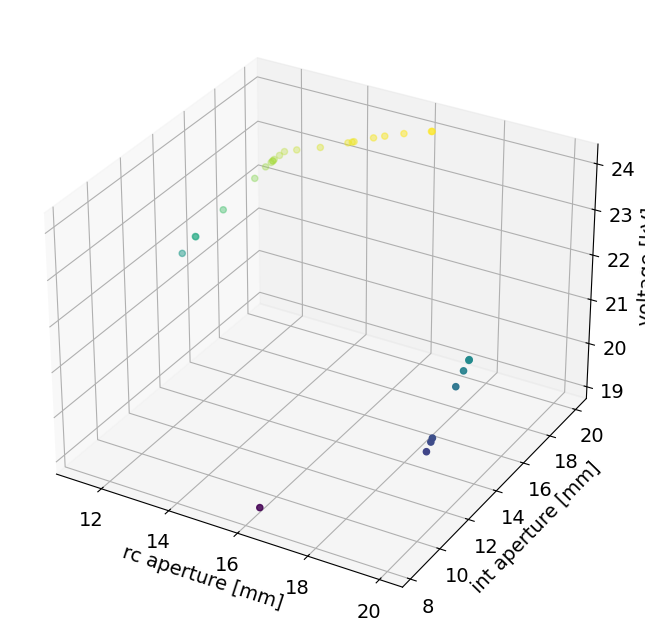

In [284]:
hit, det = np.asarray(list(frontier.means.values()))
sort_indices = np.argsort(det)

rc, wx_int, v = np.array([list(val.values()) for val in frontier.param_dicts])[
    sort_indices
].T
hit = hit[sort_indices]
det = det[sort_indices]

ax = plt.figure(figsize=(13, 8)).add_subplot(projection="3d")

ax.scatter(rc * 1e3, wx_int * 1e3, v / 1e3, c=det)


ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")

fig.tight_layout()

In [285]:
import matplotlib
import itertools


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x


xi, yi, zi = (
    np.linspace(rc.min(), rc.max(), 31) * 1e3,
    np.linspace(wx_int.min(), wx_int.max(), 31) * 1e3,
    np.linspace(v.min(), v.max(), 31) / 1e3,
)
X, Y, Z = np.meshgrid(xi, yi, zi, indexing="ij")


x, y, z = midpoints(X), midpoints(Y), midpoints(Z)


dat = np.zeros(x.shape)
face_det = np.zeros(list(x.shape))
face_hit = np.zeros(list(x.shape))
for rci, wx_inti, vi, deti, hiti in zip(rc, wx_int, v, det, hit):
    idx = np.argmin((x[:, 0, 0] - rci * 1e3) ** 2)
    idy = np.argmin((y[0, :, 0] - wx_inti * 1e3) ** 2)
    idz = np.argmin((z[0, 0, :] - vi / 1e3) ** 2)
    dat[idx, idy, idz] = 1
    face_det[idx, idy, idz] = deti
    face_hit[idx, idy, idz] = hiti


cmap = matplotlib.colormaps.get("viridis")
mapping_det = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(face_det.min(), face_det.max()), cmap=cmap
)

mapping_hit = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(face_hit.min(), face_hit.max()), cmap=cmap
)


_face_det = np.zeros(list(face_det.shape) + [3])
_face_hit = np.zeros(list(face_det.shape) + [3])
for idx, idy, idz in itertools.product(*[range(s) for s in face_det.shape]):
    _face_det[idx, idy, idz, :] = mapping_det.to_rgba(face_det[idx, idy, idz])[:3]
    _face_hit[idx, idy, idz, :] = mapping_hit.to_rgba(face_hit[idx, idy, idz])[:3]

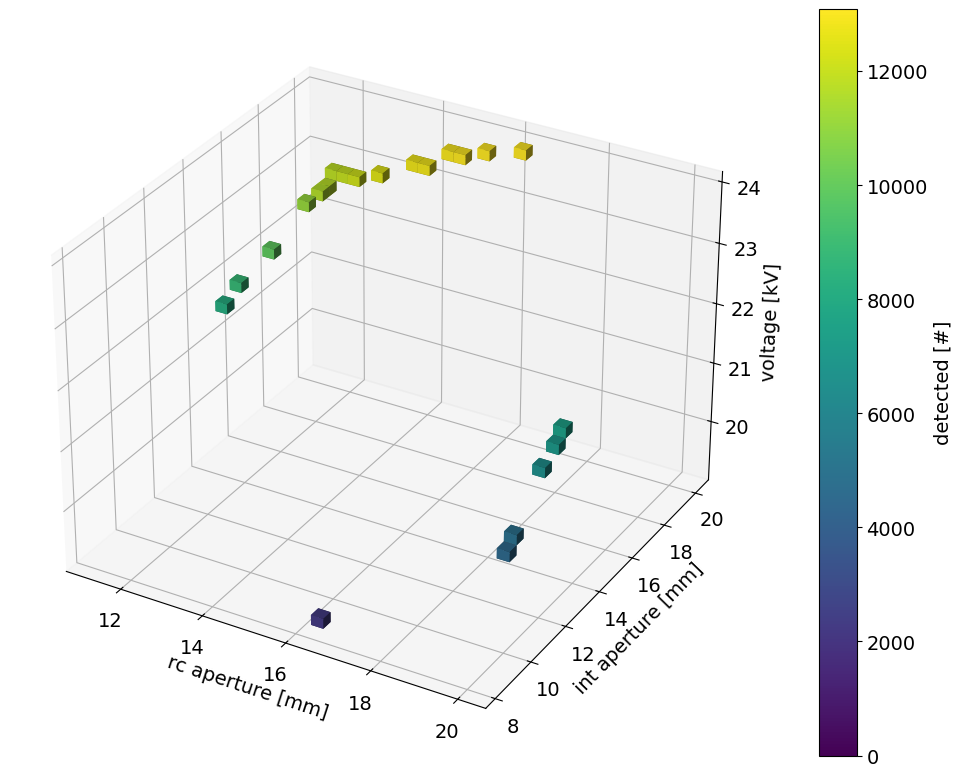

In [286]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(projection="3d")


ax.voxels(X, Y, Z, dat, facecolors=_face_det)

cbar = fig.colorbar(mapping_det, ax=ax)

ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")
cbar.ax.set_ylabel("detected [#]")

fig.tight_layout()

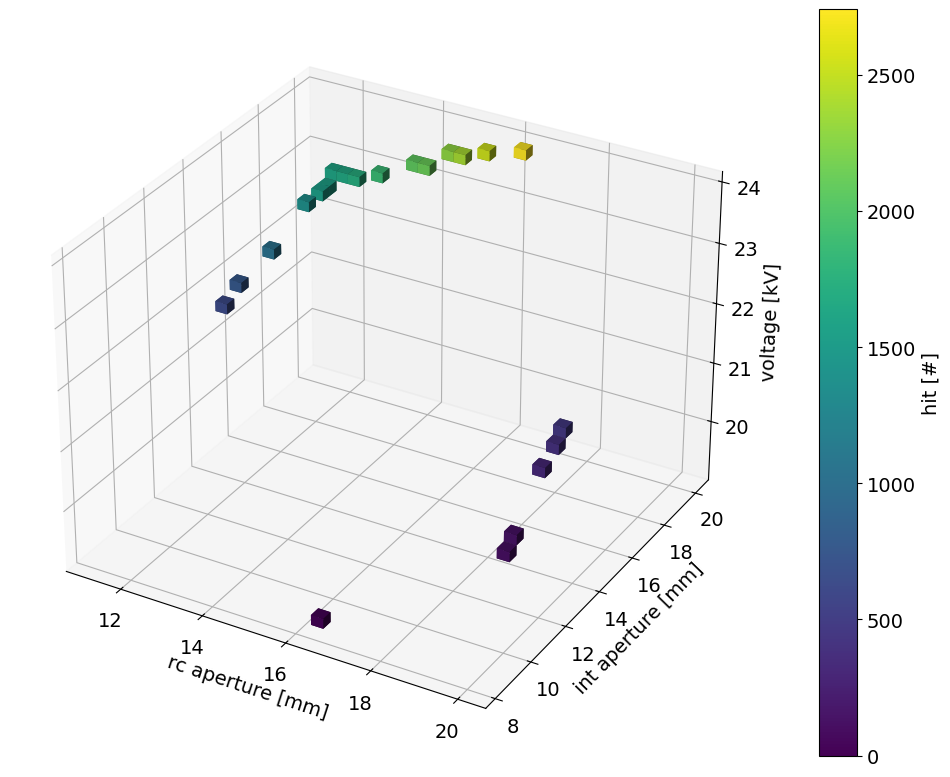

In [287]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(projection="3d")


ax.voxels(X, Y, Z, dat, facecolors=_face_hit)

cbar = fig.colorbar(mapping_hit, ax=ax)

ax.set_xlabel("rc aperture [mm]")
ax.set_ylabel("int aperture [mm]")
ax.set_zlabel("voltage [kV]")
cbar.ax.set_ylabel("hit [#]")

fig.tight_layout()

## Plot one trajectory

In [259]:
sec_dat, trajectories, sections = scan_function(
    origin,
    velocities,
    rc_radius=18e-3,
    eql_voltage=23e3,
    distance_det=5.0,
    wx_int=19.5e-3,
)

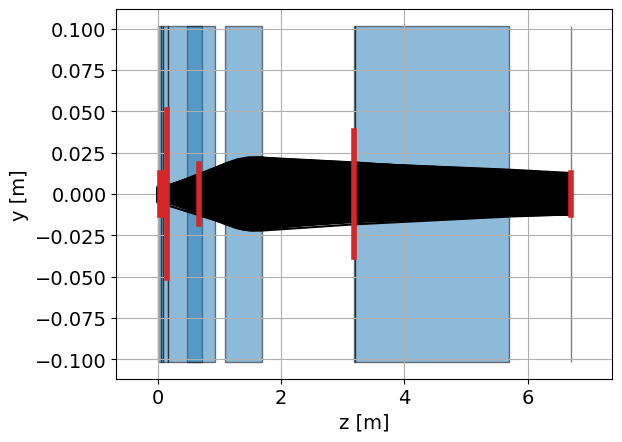

In [260]:
fig, ax = plt.subplots()

idt = 0
for traj in trajectories.values():
    ax.plot(traj.z, traj.y, color="k")
    idt += 1
    if idt == 2_000:
        break

plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

ax.grid(True)

## Scan voltages and apertures

In [19]:
n_trajectories = 40_000_000
origin = Coordinates(
    x=np.random.randn(n_trajectories) * 1.5e-3,
    y=np.random.randn(n_trajectories) * 1.5e-3,
    z=np.zeros(n_trajectories),
)
velocities = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16 + 184,
)

radii = np.arange(3e-3, 1.75 / 2 * in_to_m, 2e-3)
interaction_apertures = np.arange(4e-3, 2.1e-2, 2e-3)
voltages = np.arange(16_000, 30_001, 2_000)

data_scan = []
with progress.Progress(
    progress.SpinnerColumn(),
    progress.TextColumn(
        "{task.description} [progress.percentage]{task.percentage:>3.0f}%",
        justify="right",
    ),
    progress.BarColumn(),
    progress.MofNCompleteColumn(),
    progress.TextColumn("•"),
    TaskSpeed(),
    progress.TextColumn("•"),
    progress.TimeElapsedColumn(),
    progress.TextColumn("•"),
    progress.TimeRemainingColumn(),
) as pb:
    t1 = pb.add_task("radius", total=len(radii))
    t2 = pb.add_task("interaction", total=len(interaction_apertures))
    t3 = pb.add_task("voltage", total=len(voltages))
    for idr, radius in enumerate(radii):
        for idi, interaction in enumerate(interaction_apertures):
            for idv, voltage in enumerate(voltages):
                sec_dat, traj, secs = scan_function(
                    origin,
                    velocities,
                    radius,
                    voltage,
                    distance_det=5.0,
                    wx_int=interaction,
                    wy_int=2 * in_to_m,
                    wx_det=0.04,
                    wy_det=2 * in_to_m,
                )
                data_scan.append(
                    (
                        radius,
                        interaction,
                        voltage,
                        sec_dat[-4].saved_collisions[0][0],
                        sec_dat[-2].saved_collisions[0][0],
                        sec_dat[-1].survived,
                    )
                )
                pb.update(task_id=t3, completed=idv + 1)
            if idi < len(interaction_apertures) - 1:
                pb.reset(t3)
            pb.update(task_id=t2, completed=idi + 1)
        if idr < len(radii) - 1:
            pb.reset(t2)
            pb.reset(t3)
        pb.update(task_id=t1, completed=idr + 1)
    pb.refresh()

Output()

In [20]:
import pickle

with open("scan.pkl", "wb") as f:
    pickle.dump(data_scan, f)


In [21]:
import pickle

with open("scan.pkl", "rb") as f:
    data_scan = pickle.load(f)


In [22]:
interaction_start = (
    bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2
    + 0.6
    + 1.5
)

In [23]:
molecules_J0_F0_pulse = 24e11

voltage = 24000 V; 10398 hit / 73698 survived


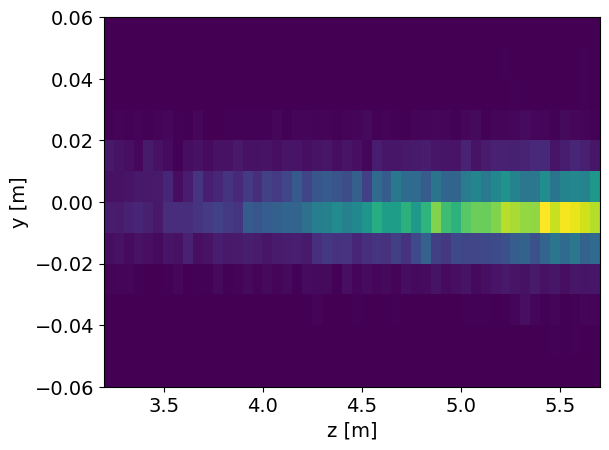

In [24]:
r, i, v, lens, plate, s = data_scan[-4]

bin_size_y = 1e-2
bin_size_z = 5e-2
fig, ax = plt.subplots()
_ = ax.hist2d(
    plate.z,
    plate.y,
    bins=(
        np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
        np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
    ),
)
ax.set_xlabel("z [m]")
ax.set_ylabel("y [m]")

print(f"voltage = {v} V; {plate.x.size} hit / {s} survived")

In [45]:
bin_size_y = 1e-2
bin_size_z = 5e-2

bins = (
    np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
    np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
)

dat_opt = []

for r, i, v, lens, plate, s in data_scan:
    hist, xedges, yedges = np.histogram2d(plate.z, plate.y, bins=bins)

    # divide hits by two because there are 2 plates
    hits_cm2 = (
        hist.max()
        * molecules_J0_F0_pulse
        / n_trajectories
        / (bin_size_y * bin_size_z * 1e4)
    ) / 2
    dat_opt.append((r, i, v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories))
dat_opt = np.asarray(dat_opt)


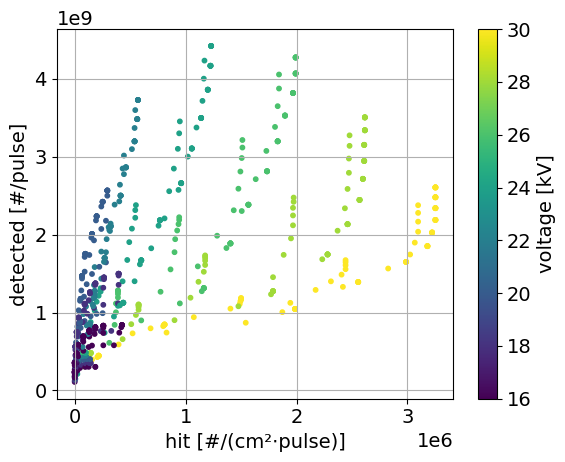

In [62]:
fig, ax = plt.subplots()

cax = ax.scatter(dat_opt[:, 3], dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3)

cbar = fig.colorbar(cax)

ax.set_xlabel("hit [#/(cm²⋅pulse)]")
ax.set_ylabel("detected [#/pulse]")
cbar.ax.set_ylabel("voltage [kV]")
ax.grid(True)


C:\Users\ogras\AppData\Local\Temp\ipykernel_29324\1901165226.py:4: RuntimeWarning: divide by zero encountered in divide
  1e15 / (dat_opt[:, 3] * 50 * 3600 * 24), dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3


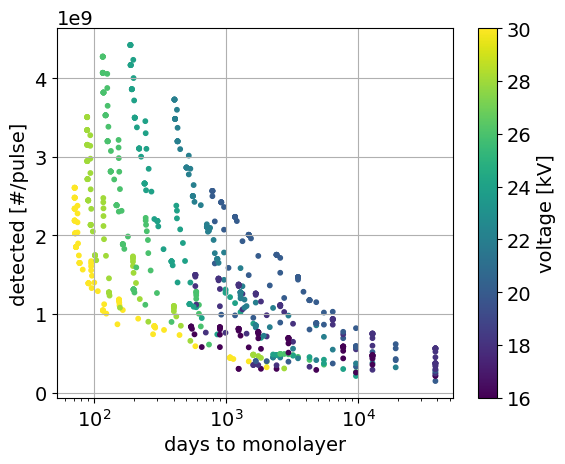

In [61]:
fig, ax = plt.subplots()

cax = ax.scatter(
    1e15 / (dat_opt[:, 3] * 50 * 3600 * 24), dat_opt[:, 4], s=10, c=dat_opt[:, 2] / 1e3
)

cbar = fig.colorbar(cax)

ax.set_xscale("log")

ax.set_xlabel("days to monolayer")
ax.set_ylabel("detected [#/pulse]")
cbar.ax.set_ylabel("voltage [kV]")
ax.grid(True)


In [98]:
import plotly.express as px

fig = px.scatter(
    x=1e15 / (dat_opt[:, 3] * 50 * 3600 * 24),
    y=dat_opt[:, 4],
    color=dat_opt[:, 2] / 1e3,
    log_x=True,
    height=500,
    width=650,
    labels={"x": "days to monolayer", "y": "detected [#/pulse]", "color": "kV"},
    hover_data={"radius": dat_opt[:, 0], "aperture": dat_opt[:, 1]},
    color_continuous_scale="viridis",
)
fig.update_layout(font=dict(size=18), yaxis={"tickformat": ".1e"})
fig.show()
fig.write_html("interactive.html")


C:\Users\ogras\AppData\Local\Temp\ipykernel_29324\2907756942.py:4: RuntimeWarning:

divide by zero encountered in divide



In [39]:
bin_size_y = 1e-2
bin_size_z = 5e-2

bins = (
    np.arange(interaction_start, interaction_start + 2.5 + 1e-3, bin_size_z),
    np.arange(-6e-2, 6e-2 + 1e-3, bin_size_y),
)

dat_opt = {}
for r, i, v, lens, plate, s in data_scan:
    hist, xedges, yedges = np.histogram2d(plate.z, plate.y, bins=bins)

    # divide hits by two because there are 2 plates
    hits_cm2 = (
        hist.max()
        * molecules_J0_F0_pulse
        / n_trajectories
        / (bin_size_y * bin_size_z * 1e4)
    ) / 2

    if (r, i) not in dat_opt:
        dat_opt[(r, i)] = (v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories)
    else:
        if dat_opt[(r, i)][-1] < s * molecules_J0_F0_pulse / n_trajectories:
            dat_opt[(r, i)] = (v, hits_cm2, s * molecules_J0_F0_pulse / n_trajectories)

dat_opt = np.array([[*key, *value] for key, value in dat_opt.items()])


Text(0, 0.5, 'int aperture [m]')

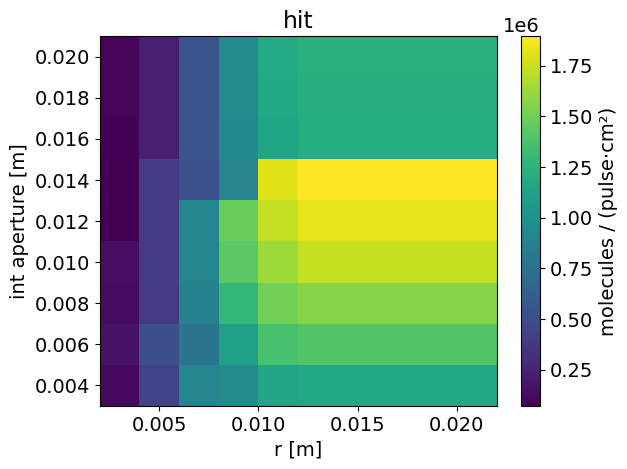

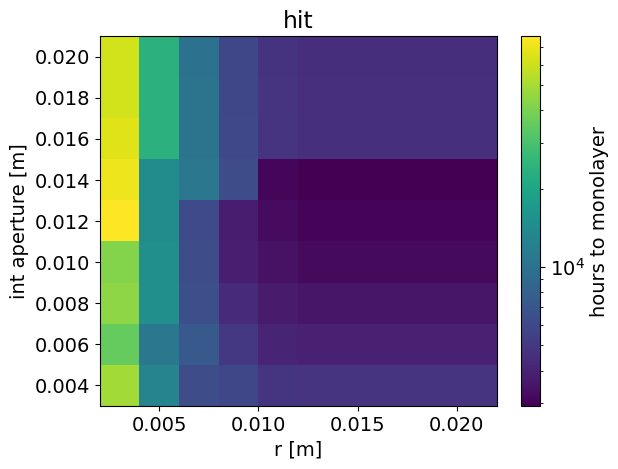

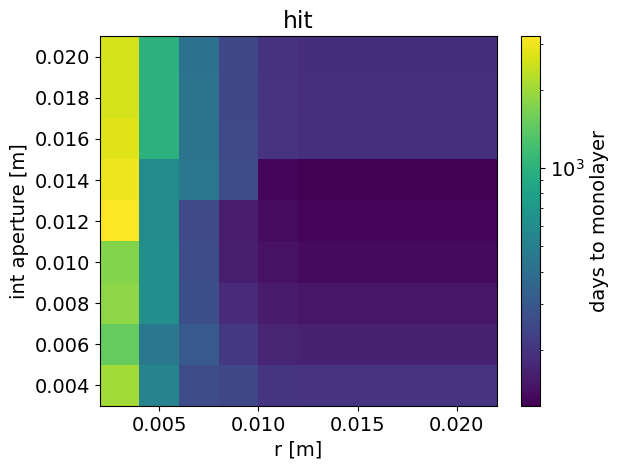

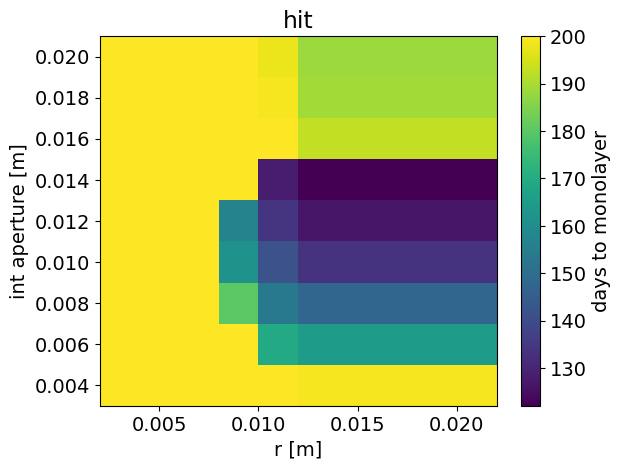

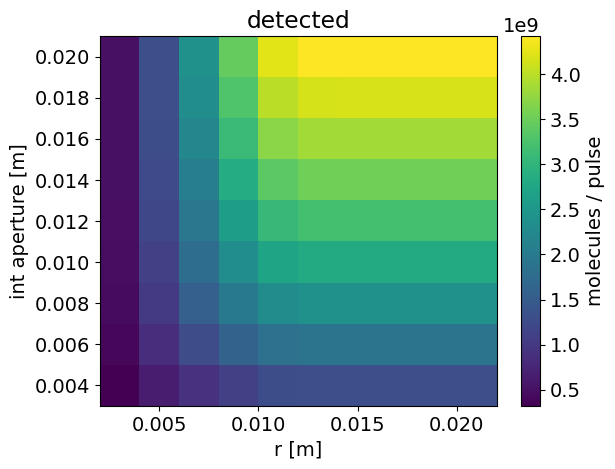

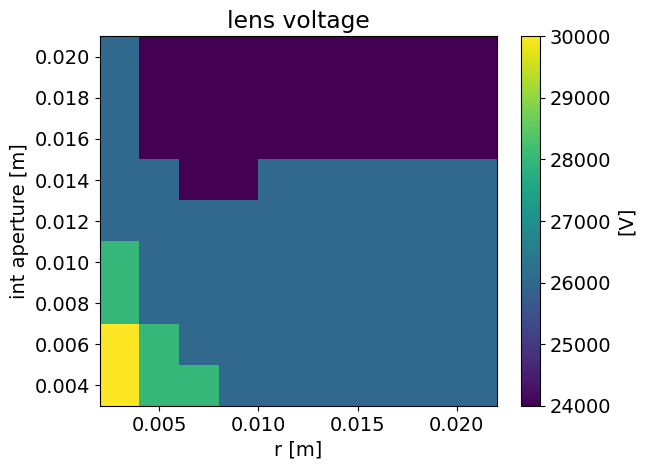

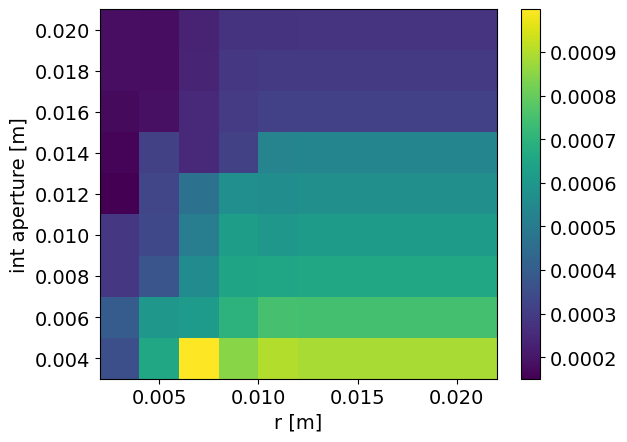

In [40]:
import matplotlib.colors as colors

tmp = dat_opt.copy()
tmp = tmp.reshape((radii.size, interaction_apertures.size, -1))

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 3])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("molecules / (pulse⋅cm²)")
ax.set_title("hit")

z = 1e15 / (tmp[:, :, 3] * 50 * 3600)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    norm=colors.LogNorm(z[np.isfinite(z)].min(), z[np.isfinite(z)].max()),
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("hours to monolayer")
ax.set_title("hit")


z = 1e15 / (tmp[:, :, 3] * 50 * 3600 * 24)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    norm=colors.LogNorm(z[np.isfinite(z)].min(), z[np.isfinite(z)].max()),
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("days to monolayer")
ax.set_title("hit")


z = 1e15 / (tmp[:, :, 3] * 50 * 3600 * 24)

fig, ax = plt.subplots()
cax = ax.pcolormesh(
    tmp[:, :, 0],
    tmp[:, :, 1],
    z,
    vmin=z.min(),
    vmax=200,
)
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("days to monolayer")
ax.set_title("hit")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 4])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("molecules / pulse")
ax.set_title("detected")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 2])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
cbar.ax.set_ylabel("[V]")
ax.set_title("lens voltage")

fig, ax = plt.subplots()
cax = ax.pcolormesh(tmp[:, :, 0], tmp[:, :, 1], tmp[:, :, 3] / tmp[:, :, 4])
cbar = fig.colorbar(cax)

ax.set_xlabel("r [m]")
ax.set_ylabel("int aperture [m]")
